In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from scipy.optimize import curve_fit
from scipy.signal import spectrogram, periodogram, butter, filtfilt
import matplotlib.dates as mdates
from scipy.fft import fftshift
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from datetime import timedelta

### Time Series Descomposition

Para este análisis se utiliza el campo GROCERIES I de la tabla de train con el objetivo de simplificar el análisis. 

In [231]:
# Upload datasets
datasets = {}
datasets["oil"] = pd.read_csv("data/oil.csv")
datasets["stores"] = pd.read_csv("data/stores.csv")
datasets["train"] = pd.read_csv("data/train.csv")
datasets["test"] = pd.read_csv("data/test.csv")
datasets["transactions"] = pd.read_csv("data/transactions.csv")
datasets["holidays"] = pd.read_csv("data/holidays_events.csv")

In [232]:
# Transform rows to datetime
for _, dataset in datasets.items():
    if "date" in dataset.columns:
        dataset["date"] = pd.to_datetime(dataset["date"])

In [233]:
family = "GROCERY I"
sales_per_day_dataset = datasets["train"][datasets["train"]["family"] == family].groupby(datasets["train"]['date'].dt.date).sum()["sales"]


In [234]:

sales_per_day_dataset.index = pd.to_datetime(sales_per_day_dataset.index)

### Check for missing values

Se imputan los datos faltantes interpolando entre dos puntos vecinos

In [235]:
def impute_interpolation(dataset, missing):
      time_change = timedelta(days=1)
      dataset[(missing[0] + time_change).strftime('%Y-%m-%d')]
      for miss in missing:
            dataset.loc[miss] = (dataset[miss + time_change] + dataset[miss - time_change]) / 2
      return dataset

In [236]:

my_range = pd.date_range(start="2013-01-01", end="2017-08-15", freq='B')
difference = my_range.difference(sales_per_day_dataset.index)
print(difference)

dataset = impute_interpolation(sales_per_day_dataset, difference)

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25'], dtype='datetime64[ns]', freq=None)


In [237]:
sales_per_day_dataset = sales_per_day_dataset.sort_index()
sales_per_day = sales_per_day_dataset[:1600]
sales_per_day_test = sales_per_day_dataset[1600:]

In [238]:
sales_per_day

date
2013-01-01       700.000
2013-01-02    202020.000
2013-01-03    144878.000
2013-01-04    135754.000
2013-01-05    188356.000
                 ...    
2017-05-16    241186.132
2017-05-17    242271.766
2017-05-18    189992.941
2017-05-19    225889.530
2017-05-20    314630.342
Name: sales, Length: 1600, dtype: float64

In [239]:
print(sales_per_day.loc["2013-12-25"])

sales_per_day

217349.0


date
2013-01-01       700.000
2013-01-02    202020.000
2013-01-03    144878.000
2013-01-04    135754.000
2013-01-05    188356.000
                 ...    
2017-05-16    241186.132
2017-05-17    242271.766
2017-05-18    189992.941
2017-05-19    225889.530
2017-05-20    314630.342
Name: sales, Length: 1600, dtype: float64

### Autocorrelation

In [240]:
#x = pd.plotting.autocorrelation_plot(sales_per_day.values)
#x.plot()

Primero se hace un análisis de la serie de tiempo para determinar si la serie es estacionario. Se hace utiliza el test de Dickey-Fuller.

In [241]:
adfuller(sales_per_day.values)

(-3.875393716875627,
 0.002223586740570218,
 22,
 1577,
 {'1%': -3.4345034408379527,
  '5%': -2.863374496477375,
  '10%': -2.567746652650719},
 37182.46595073718)

Dado que de obtiene un p-valor de 0.009 podemos decir que la serie es estacionaria. Por lo que la serie es invariante a lo largo del tiempo

Se grafica la función de autocorrelación muestreal

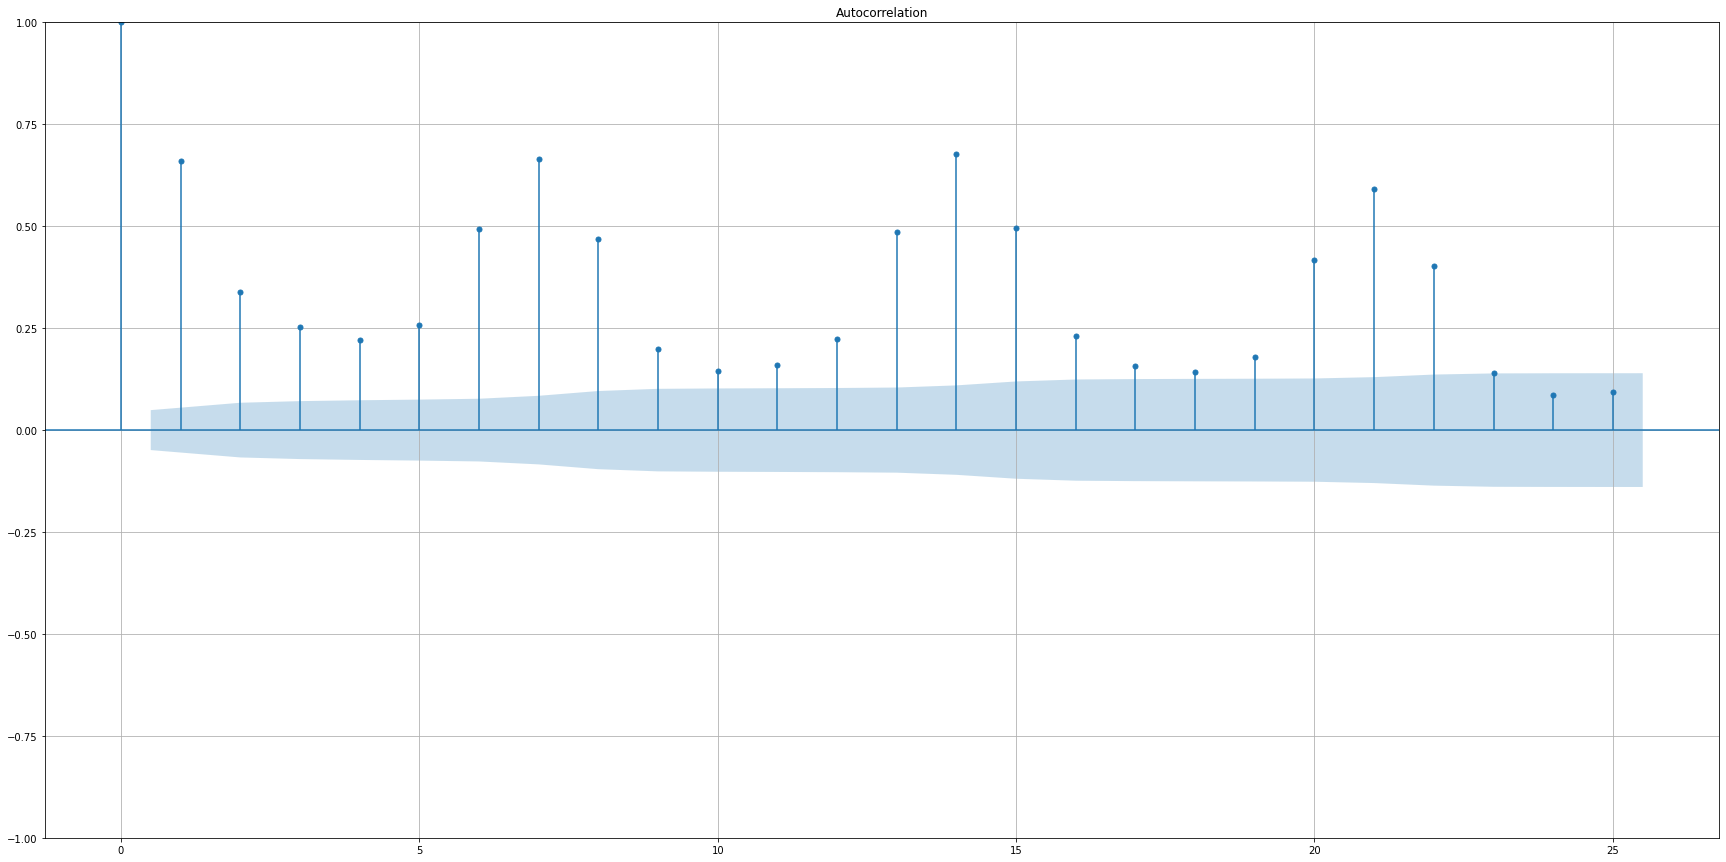

In [242]:
plot_acf(sales_per_day.values, lags=25)
plt.grid()
plt.show()

Se grafica la función de autocorrelación parcial

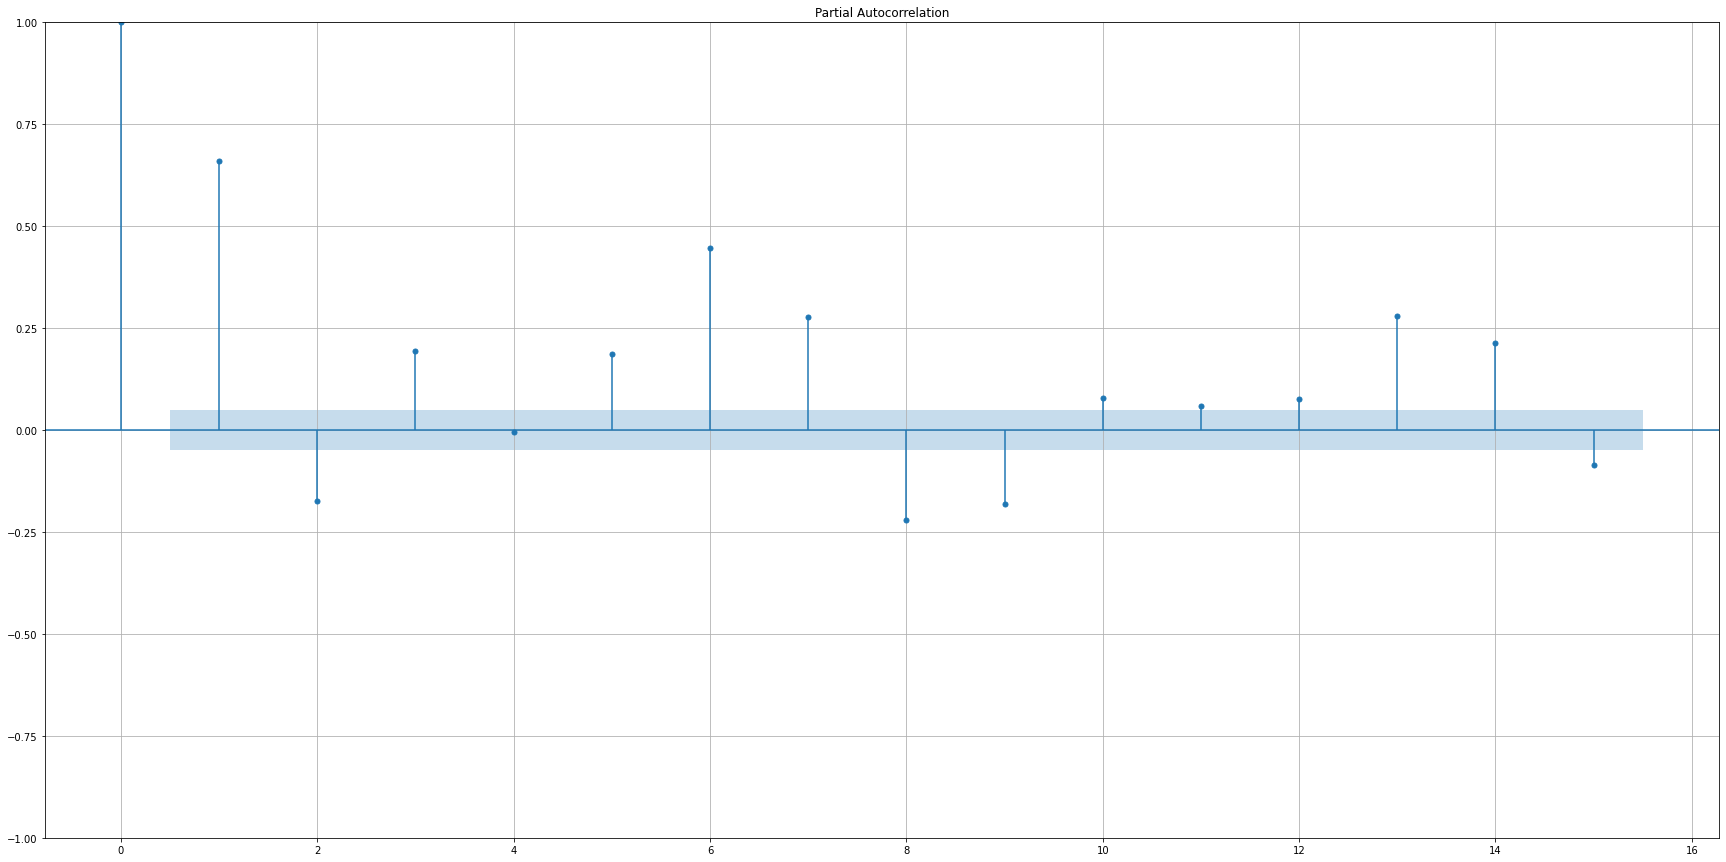

In [243]:
plot_pacf(sales_per_day.values, lags=15, method="ywm")
plt.grid()
plt.show()

### Additive descomposition

Posteriormente se realiza la descomposición de la serie de tiempo usando seasonal_decompose de forma aditiva

<Figure size 1440x4320 with 0 Axes>

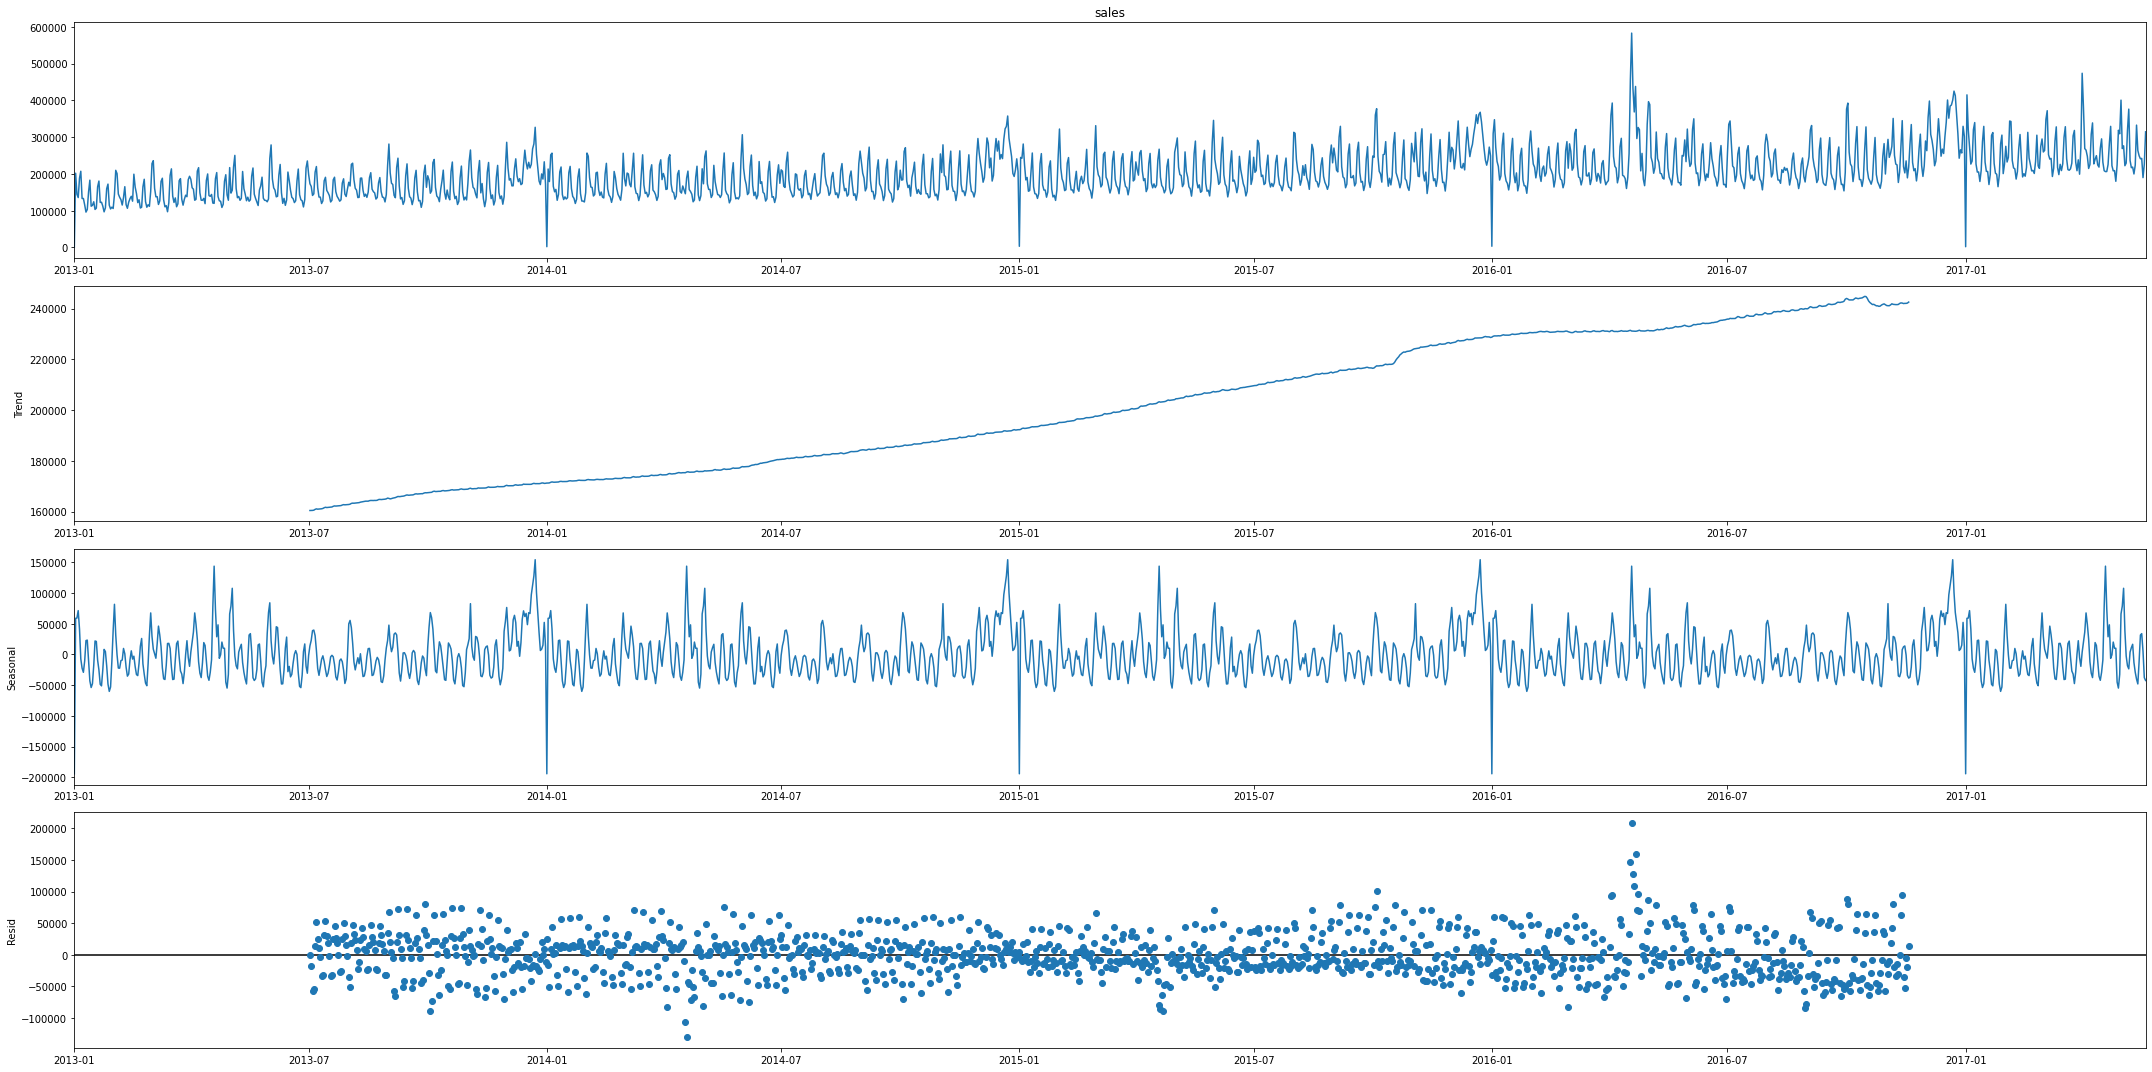

<Figure size 1440x4320 with 0 Axes>

In [244]:
result = seasonal_decompose(sales_per_day, model='additive', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Multiplicative descomposition

Luego se hace la descomposición de forma multiplicativa

<Figure size 1440x4320 with 0 Axes>

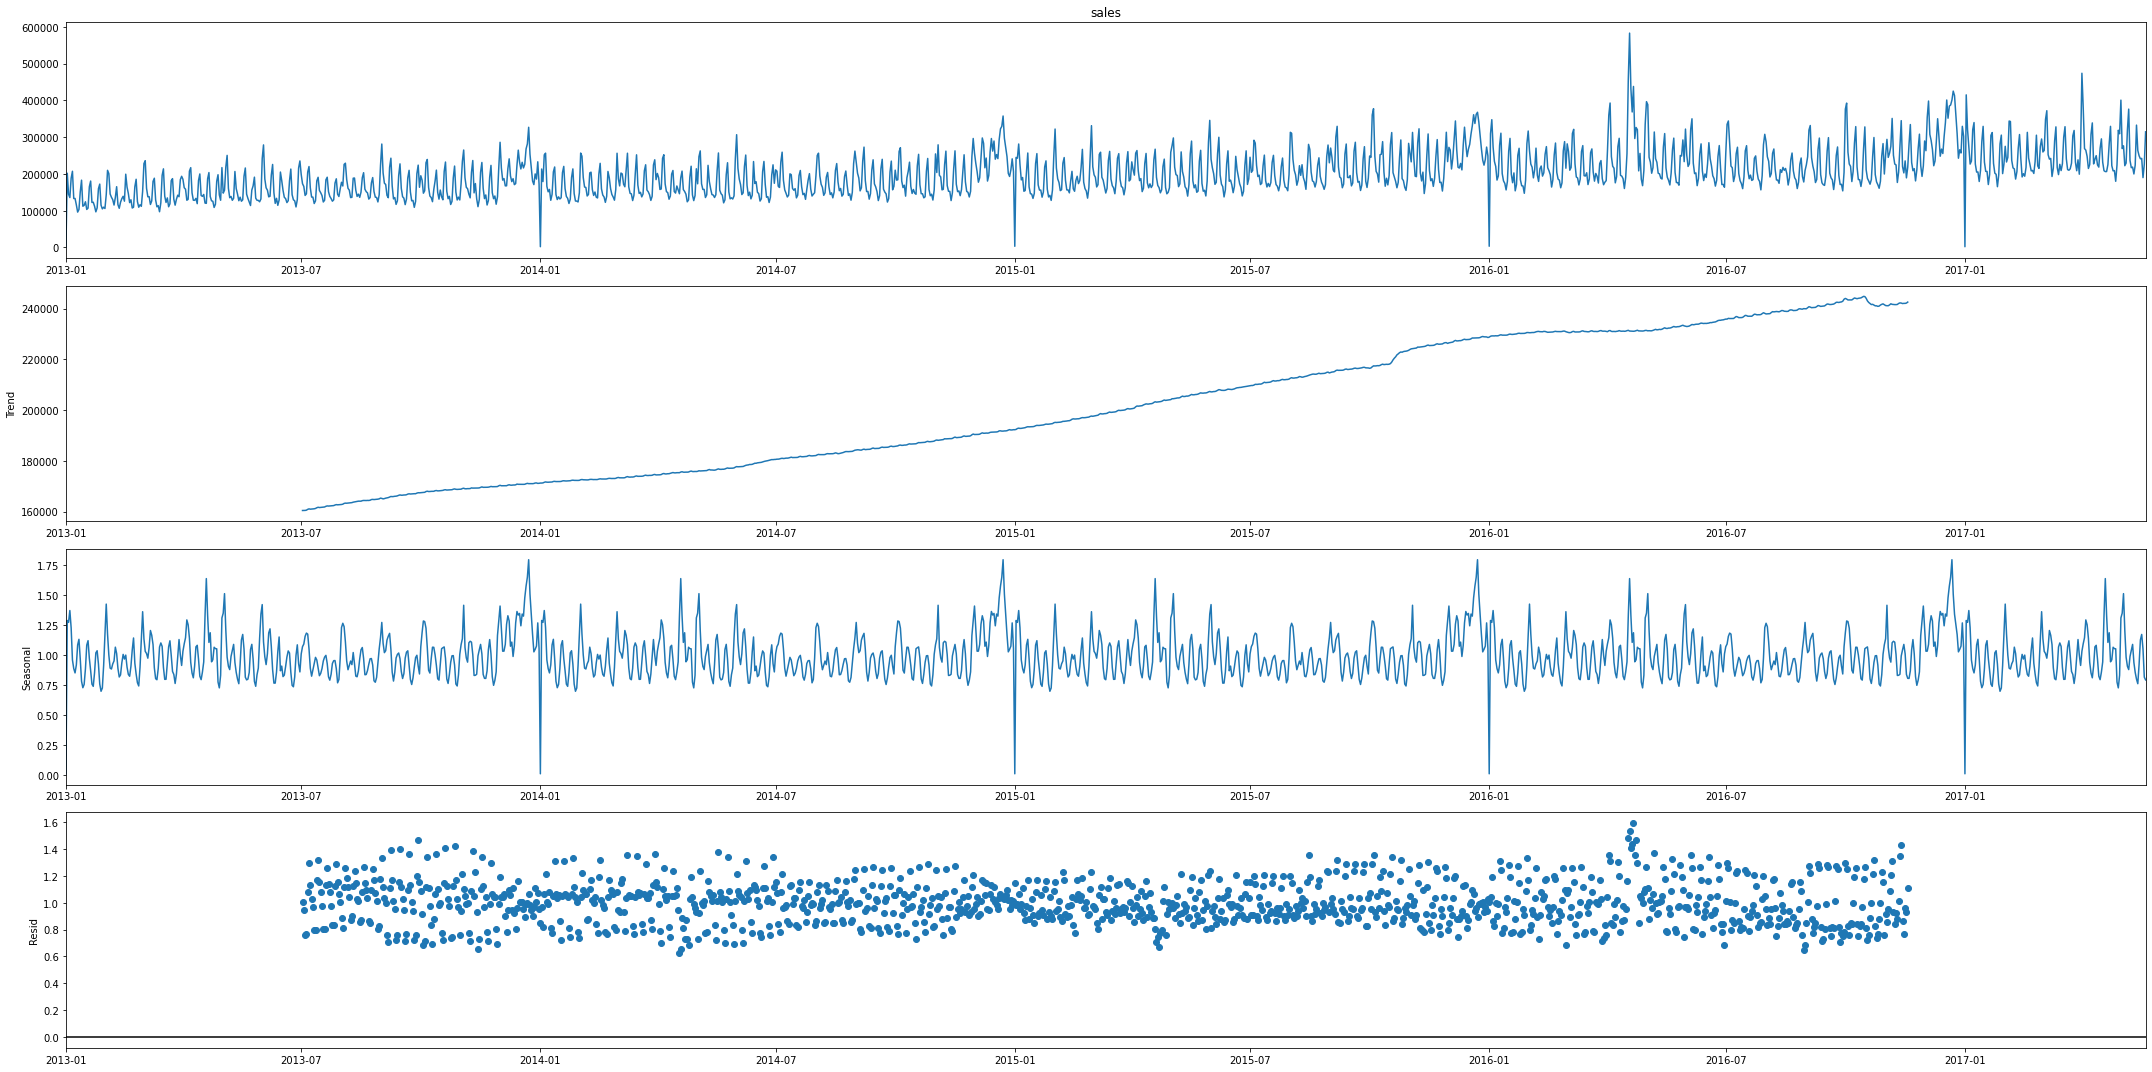

<Figure size 1440x4320 with 0 Axes>

In [245]:
result = seasonal_decompose(sales_per_day, model='multiplicative', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Descomposition using LOESS

<Figure size 1440x4320 with 0 Axes>

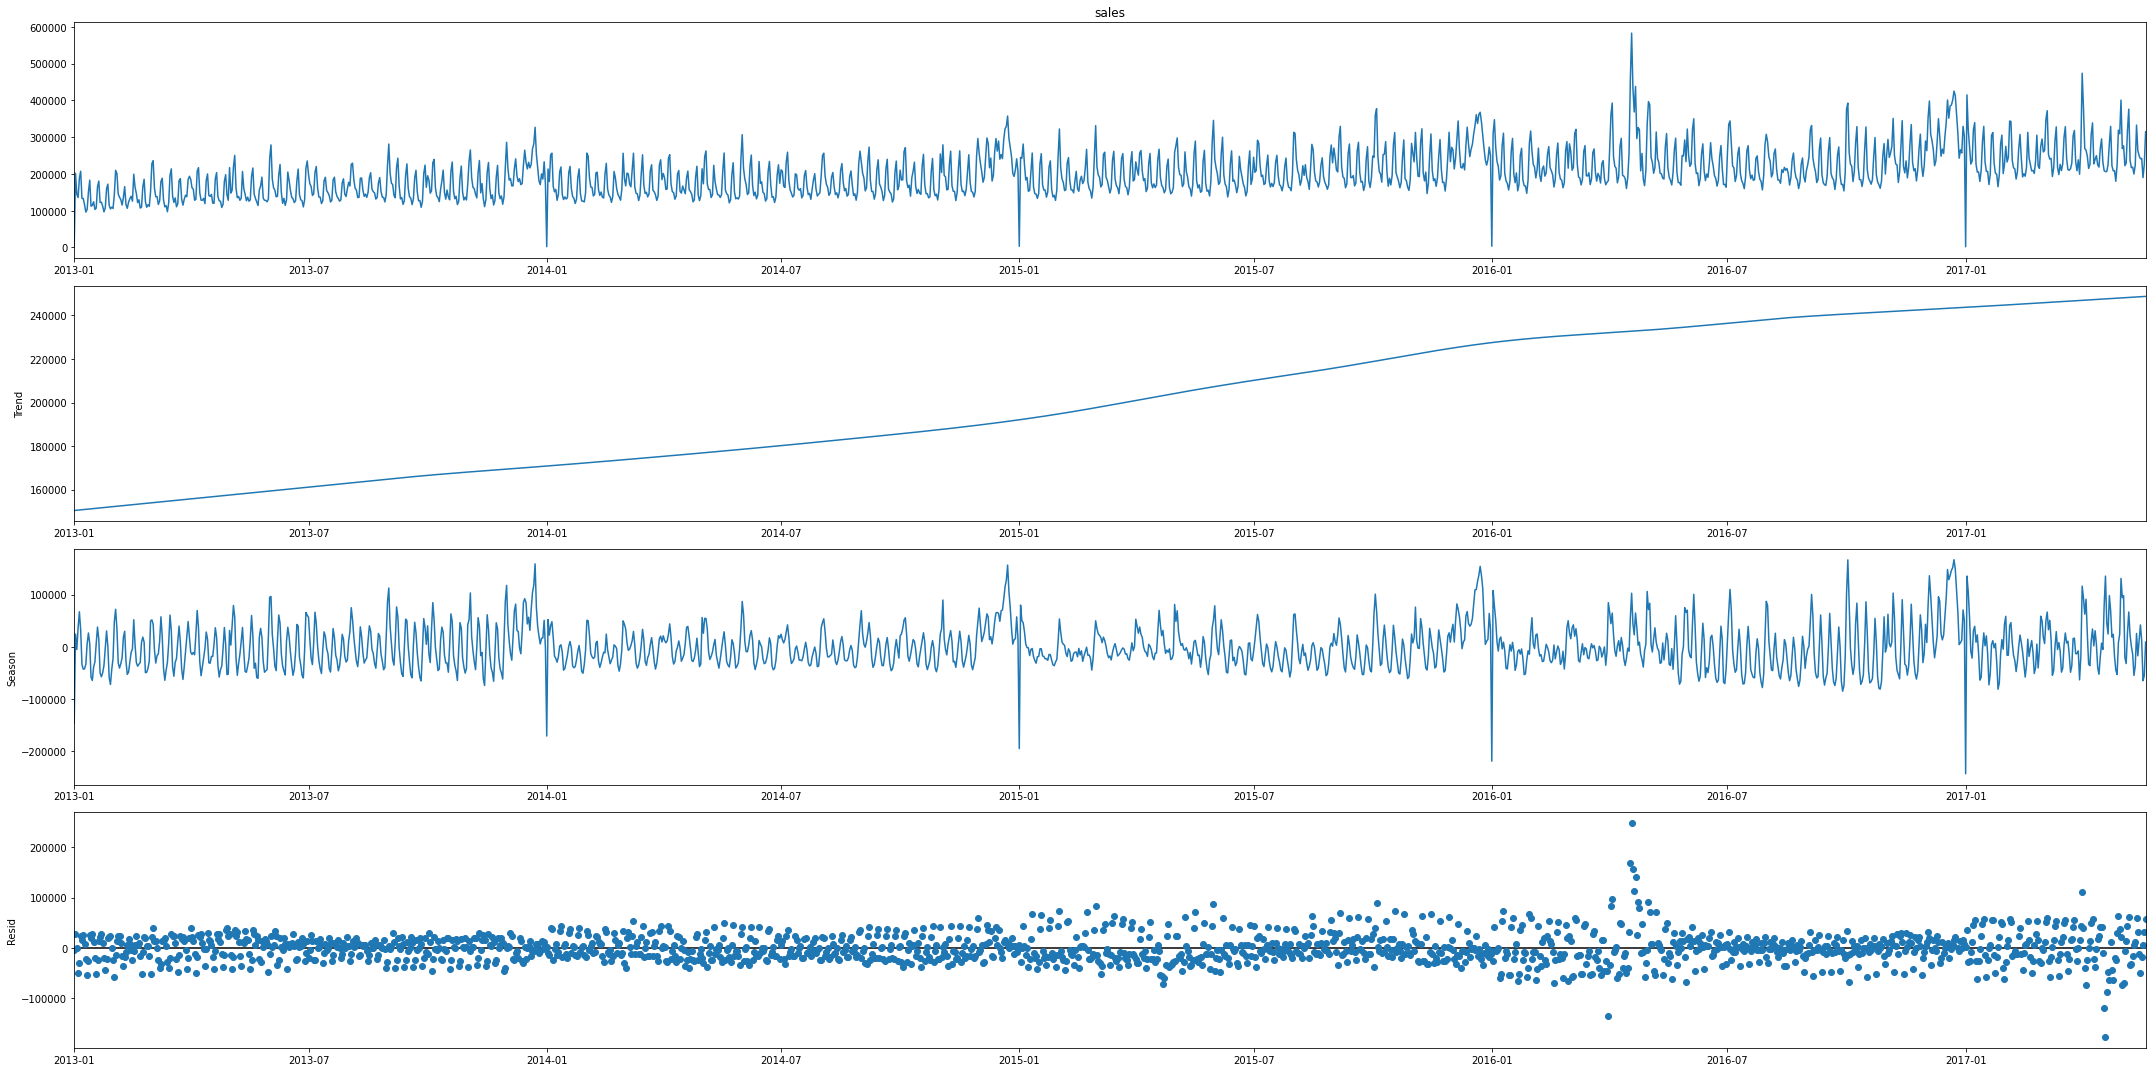

<Figure size 1440x4320 with 0 Axes>

In [246]:
res = STL(sales_per_day, period=365, seasonal=365).fit()
res.plot()
plt.figure(figsize=(20, 60))

### Trend

Se obtiene la tendencia a través de mínimos cuadrados

In [247]:

def plot_trend(series, model="linear"):

    if model == "cuadratic":
        def objective(x, a, b, c):
            return a * x + b * x ** 2 + c
    else:
        def objective(x, a, b):
            return a * x + b

    x = mdates.date2num(series.index)
    y = series.values

    popt, _ = curve_fit(objective, x, y)
    print(f"Model coefficients {popt}")


    x_line = np.arange(min(x), max(x), 1)
    print(len(x_line))
    print(len(series.index))
    print(len(mdates.date2num(series.index)))
    y_line = objective(x_line, *popt)

    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.plot(x_line, y_line)
    plt.plot(x, y)
    return y_line, popt


    

Model coefficients [ 7.31262952e+01 -1.00557910e+06]
1600
1600
1600


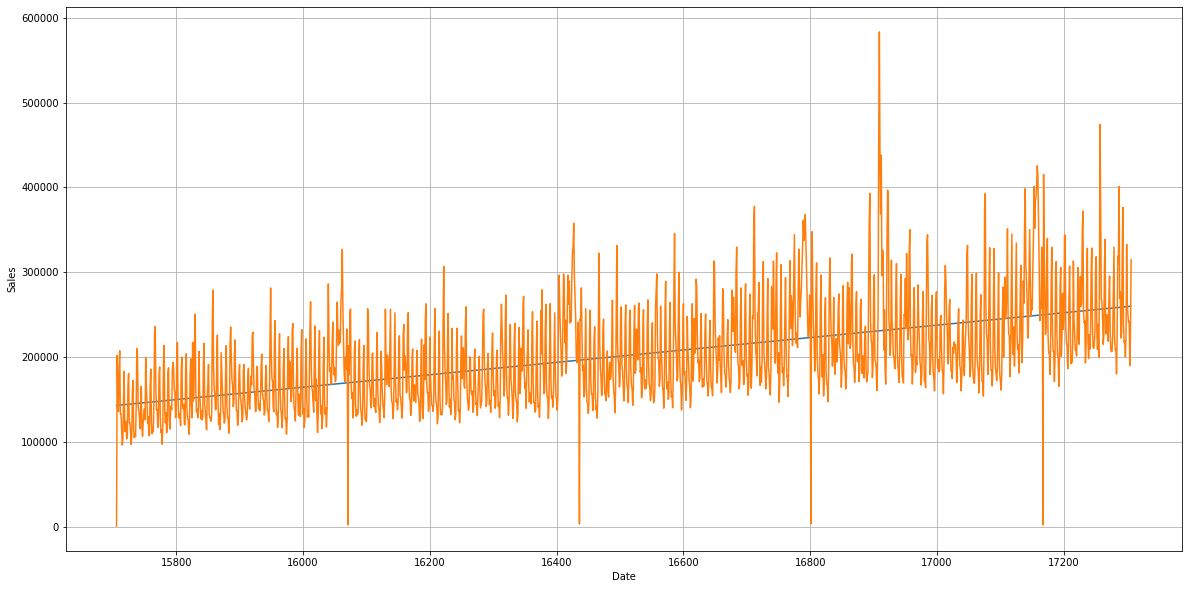

In [248]:
tendency, popt = plot_trend(sales_per_day)

In [249]:
#plot_trend(sales_per_day, model="cuadratic")

Se elimina la tendencia de la serie

In [250]:
sales_per_day = sales_per_day - tendency

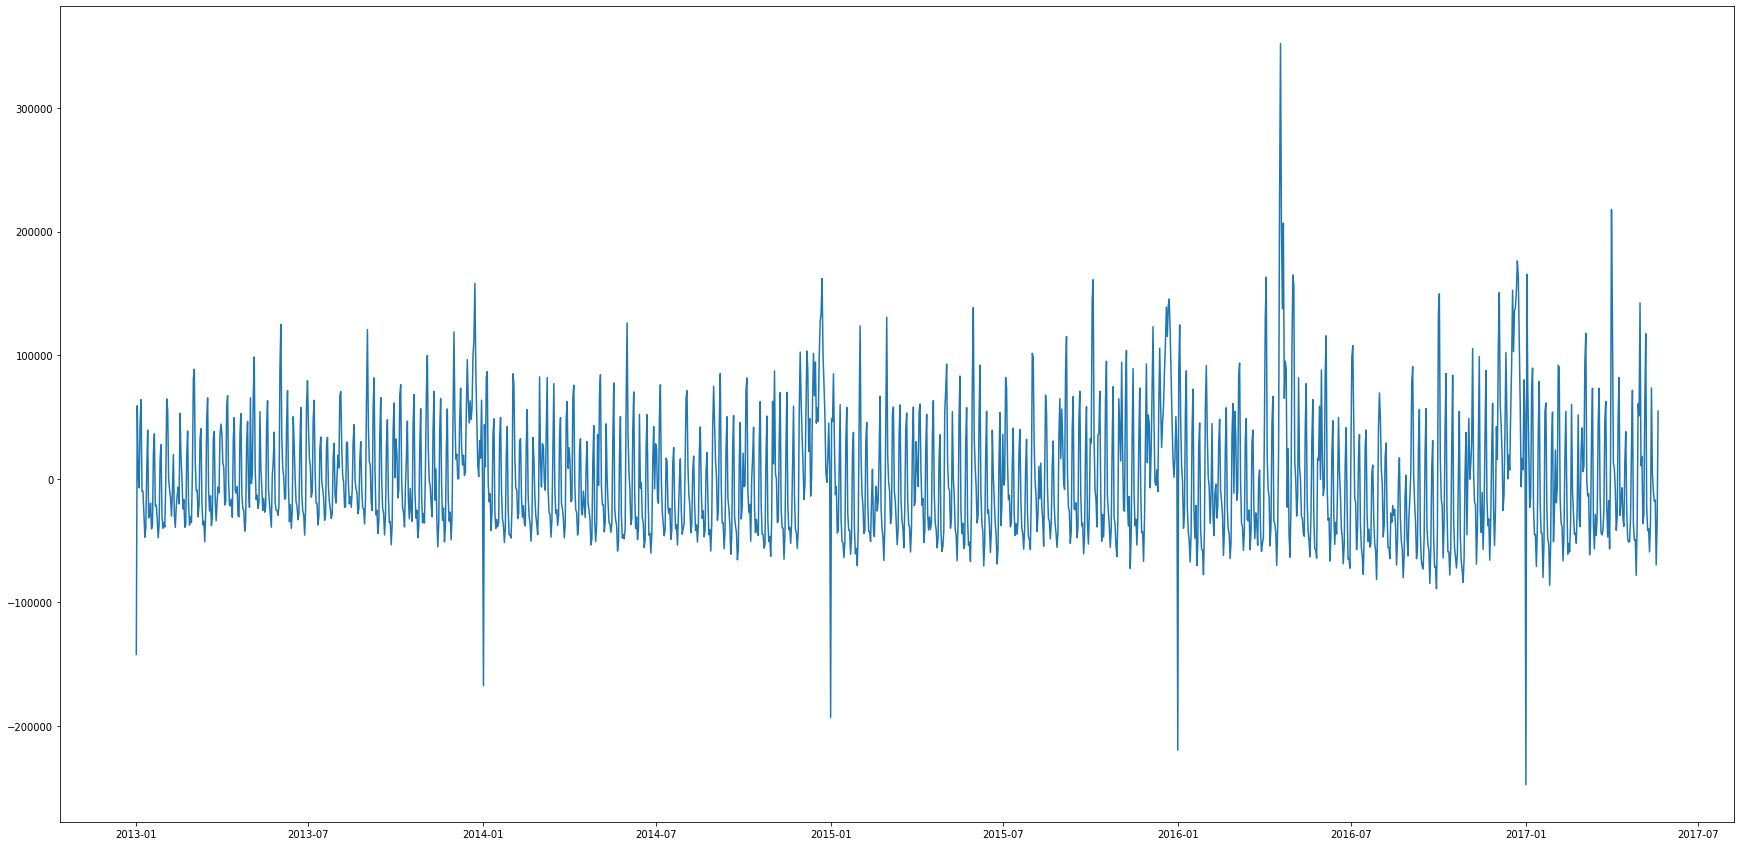

In [251]:
plt.plot(sales_per_day)

### Cycle

Se grafica el periodograma de la serie

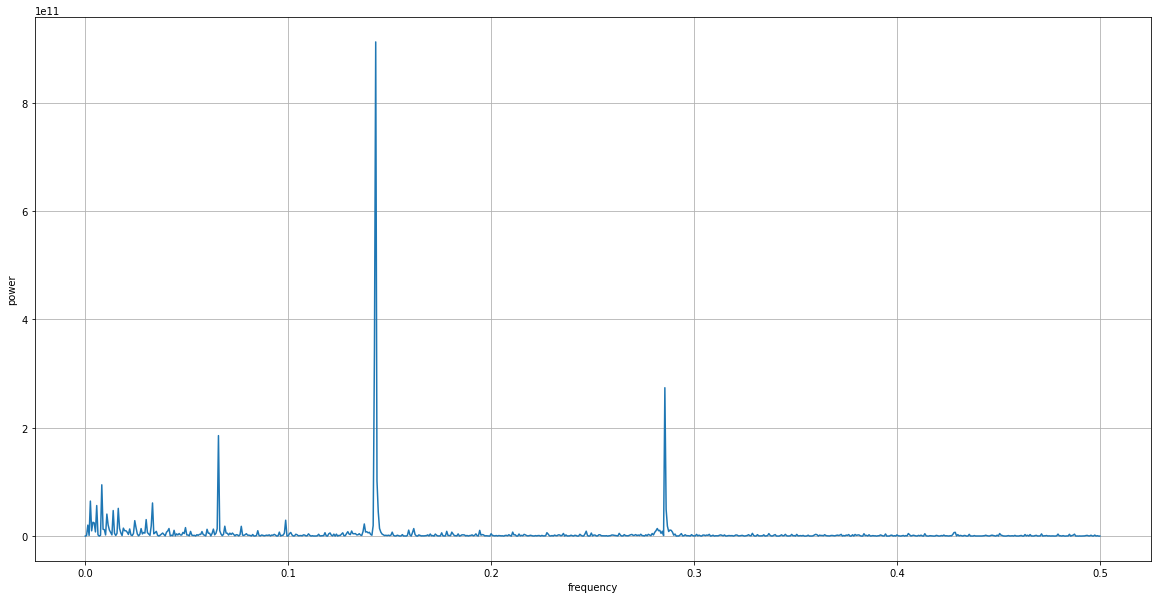

In [252]:
freq, power  = periodogram(sales_per_day.values)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)


Puede observarse una componenente semanal bastante marcada. Se observan picos a periodos de 3,5 días y dos semanas.

Se obtiene el espectrograma

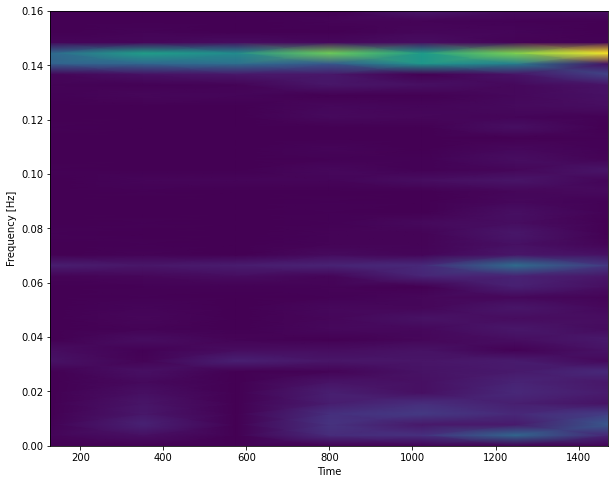

In [253]:
#<plt.plot(spectrogram(sales_per_day.values))
f, t, Sxx = spectrogram(sales_per_day.values)

plt.figure(figsize=(10, 8))
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time')
plt.ylim([0, 0.16])
plt.show()

Se puede observar en el espectrograma que se produce ciclos a una frecuencia de aproximadamente 0.14 Hz, esto corresponde a un ciclo semanal.

In [254]:
#plt.figure(figsize=(10, 8))
#powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sales_per_day.values, Fs=1, cmap="rainbow")

Se utiliza un filtro pasa banda para determinar la componente cicloidal

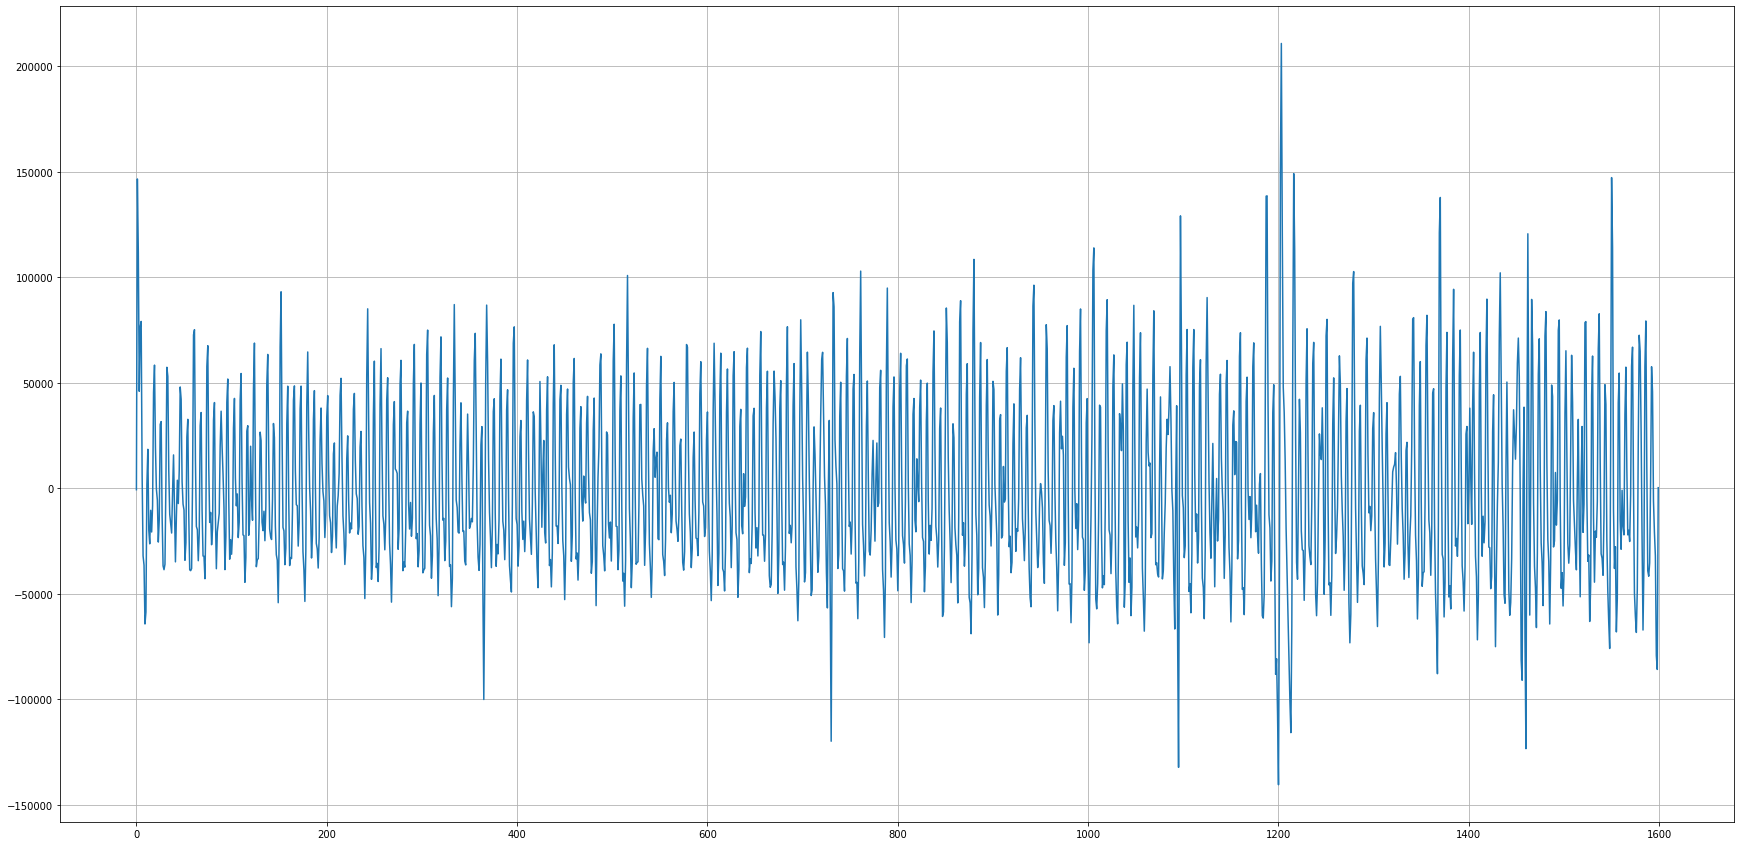

In [255]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cut / nyq for cut in cutoff]
    b, a = butter(order, normal_cutoff, btype="bandpass", analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


#filtered_data = butter_highpass_filter(sales_per_day.values, 100, 1000)
#plt.grid()
#plt.plot(filtered_data)

filtered_data = butter_bandpass_filter(sales_per_day.values, [50, 300], 1000)
plt.grid()
plt.plot(filtered_data)


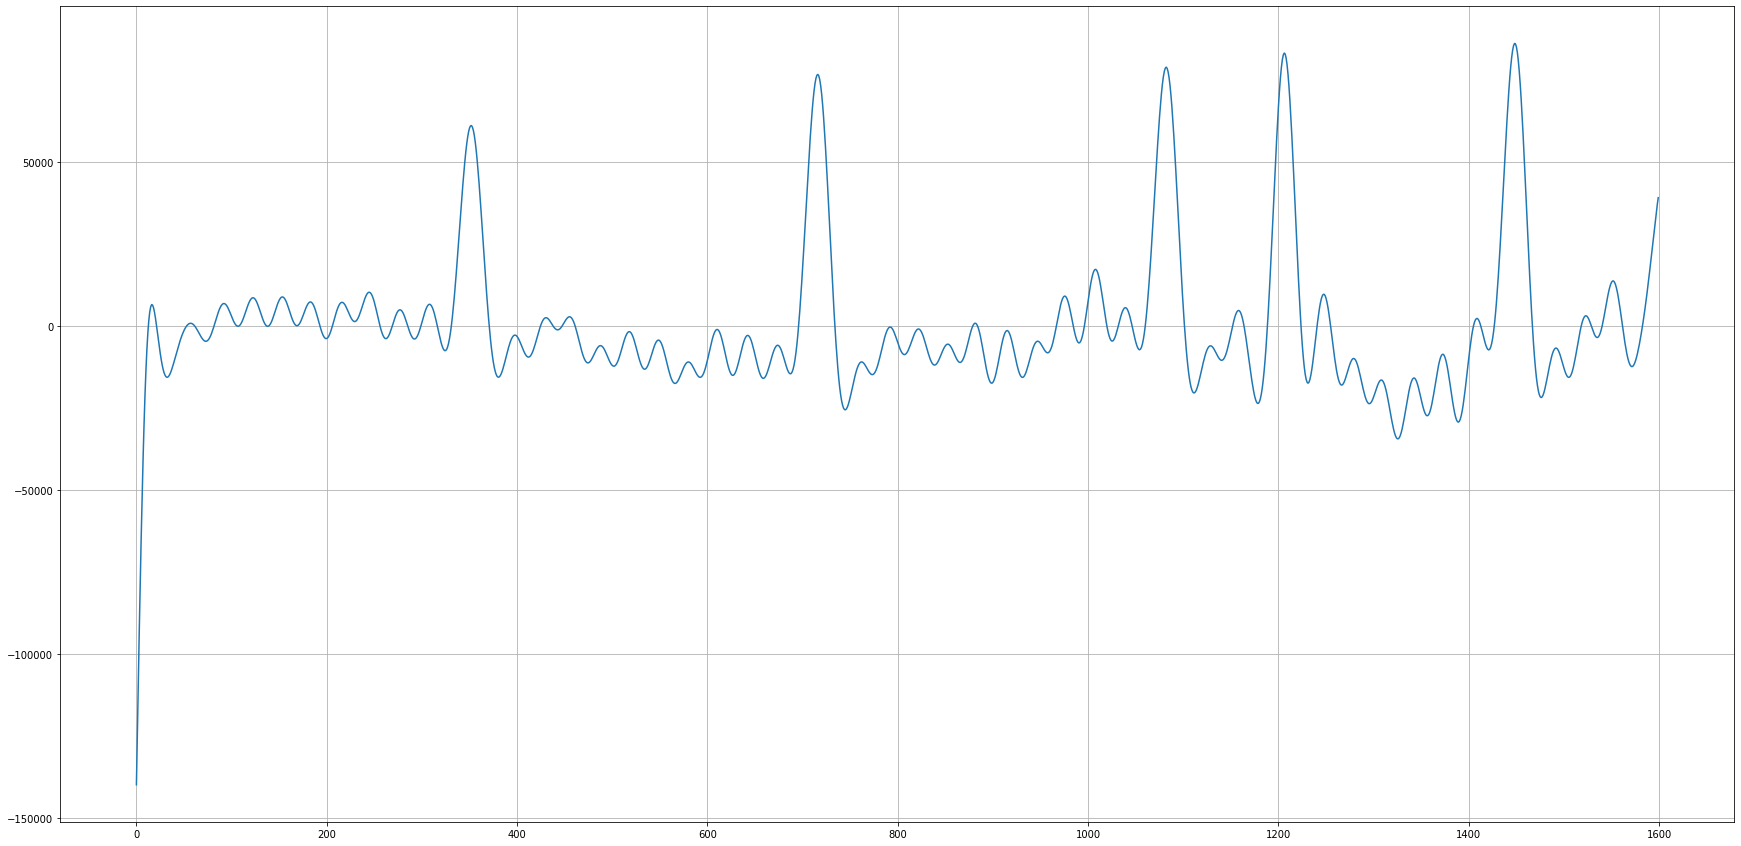

In [256]:
low_filtered_data = butter_lowpass_filter(sales_per_day.values, 30, 1000)
plt.grid()
plt.plot(low_filtered_data)

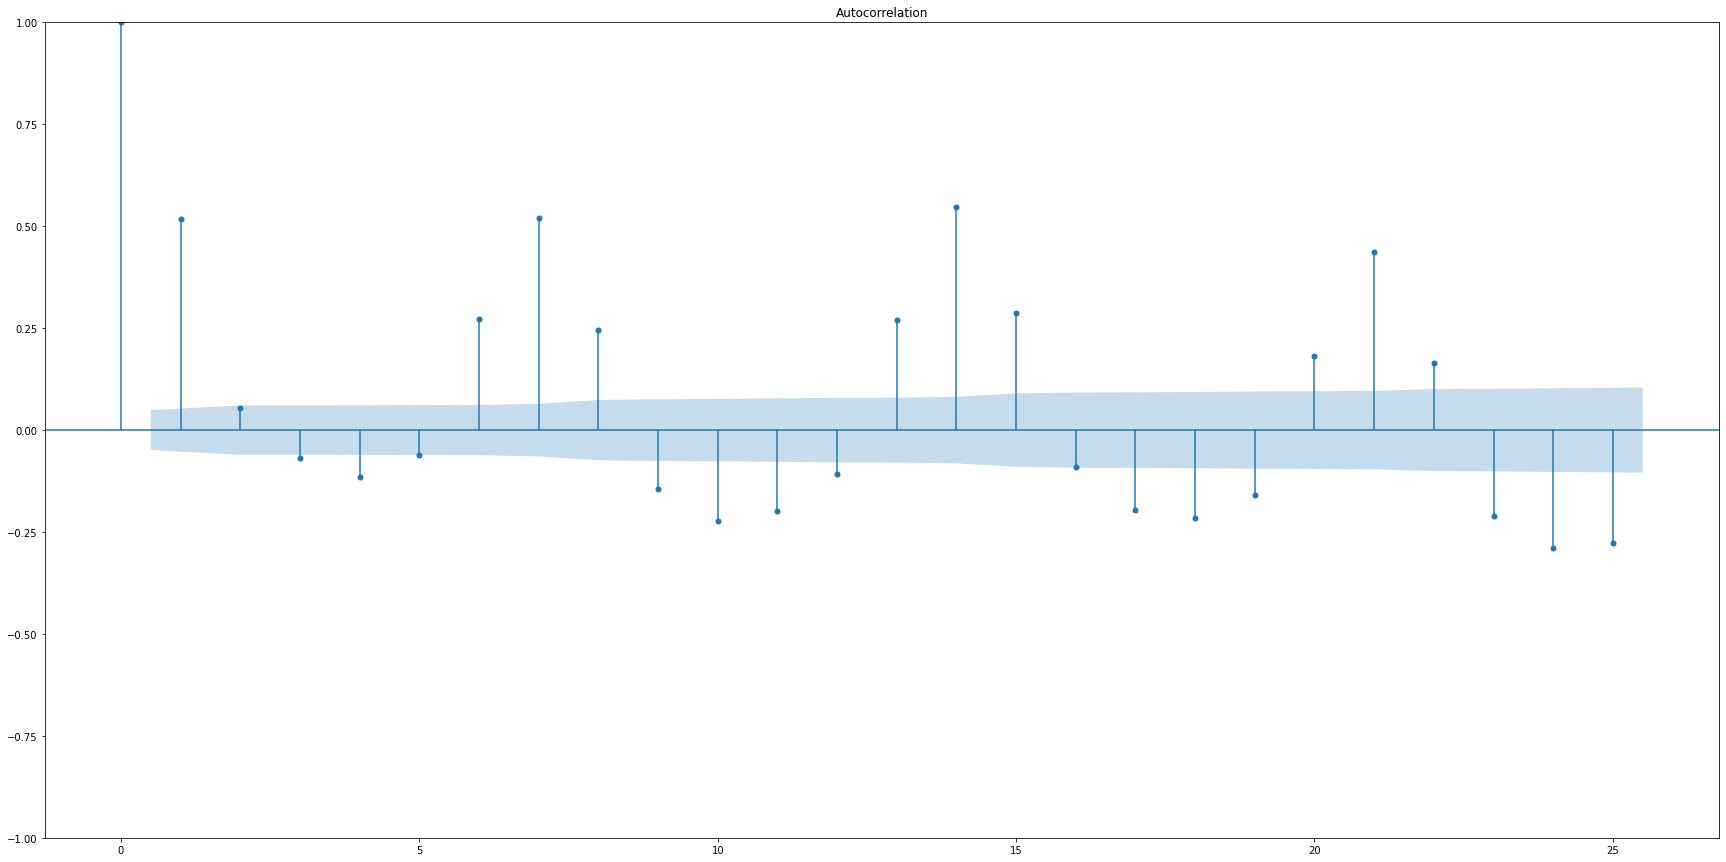

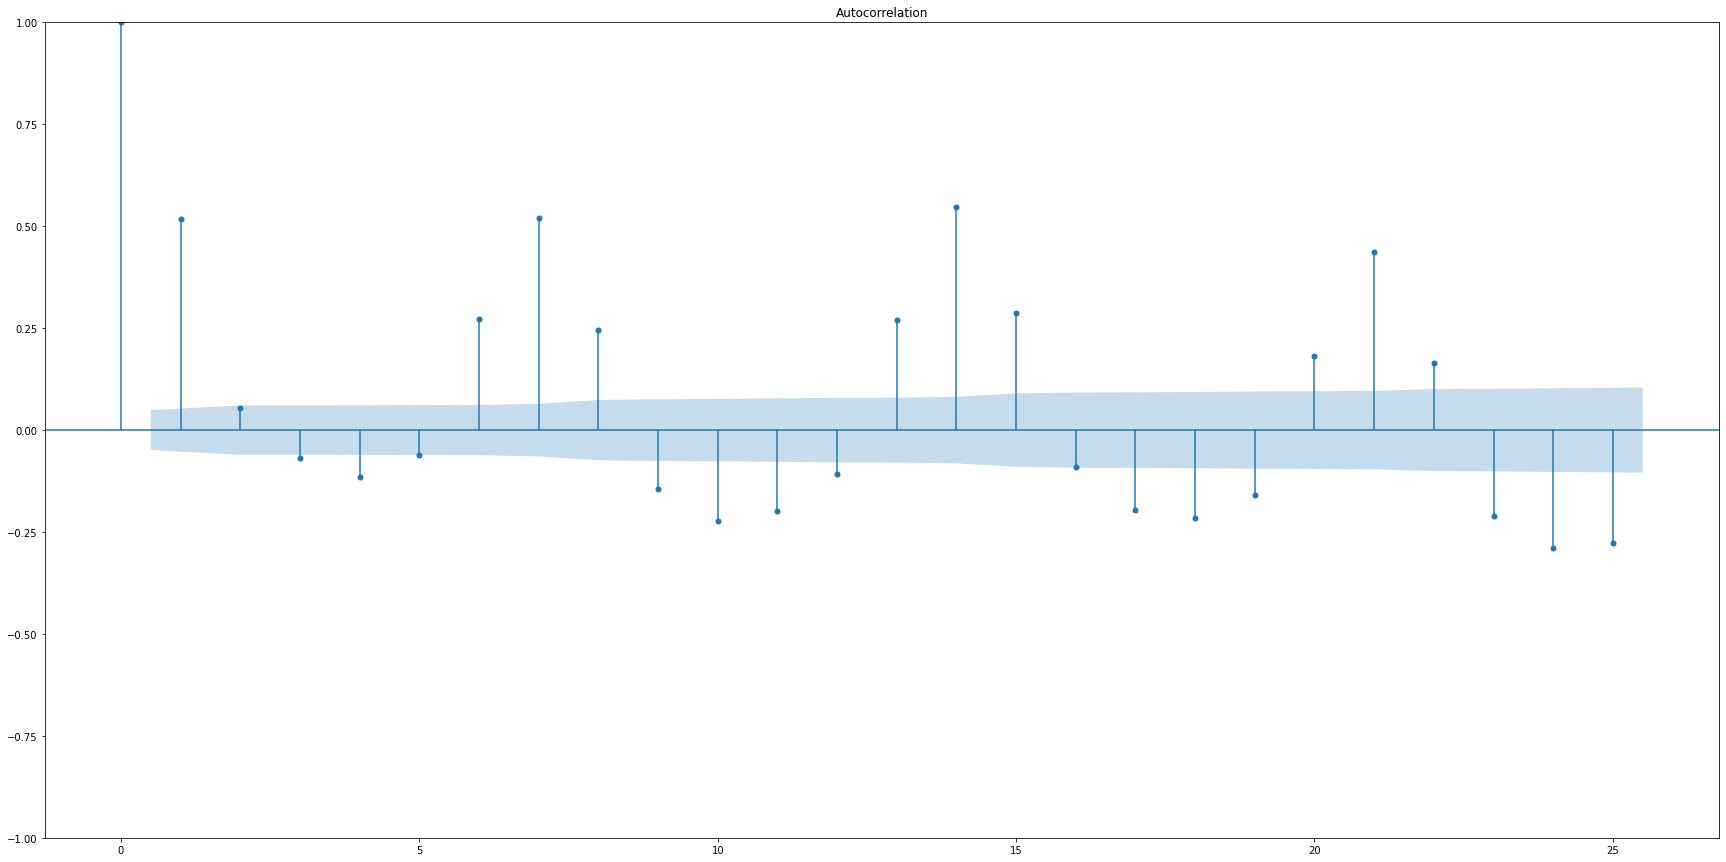

In [257]:
plot_acf(sales_per_day.values, lags=25)

Se observa

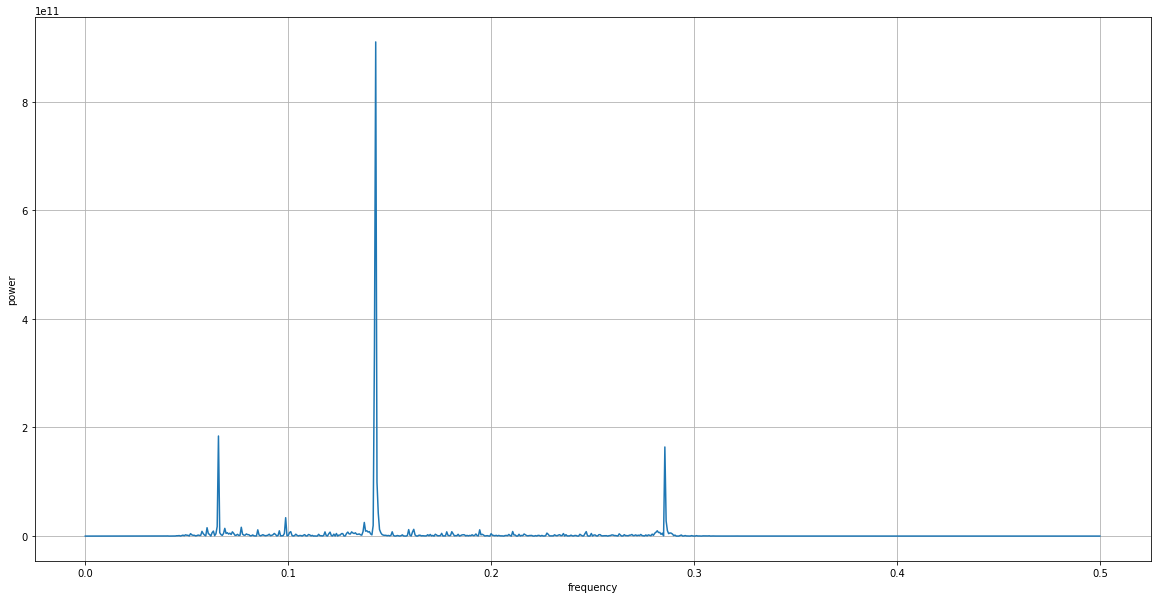

In [258]:
freq, power  = periodogram(filtered_data)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)

### ARIMA

Se modela la serie usando ARIMA, se obtienen los parámetros a partir de las gráficas de autocorrelación

In [288]:
d = 0 # No differenciation needed since time series is already stationary
q = 20
p = 3
arima = ARIMA(sales_per_day.values, order=(p, d, q))
arima_res = arima.fit()
print(arima_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1600
Model:                ARIMA(3, 0, 20)   Log Likelihood              -18935.375
Date:                Tue, 07 Jun 2022   AIC                          37920.751
Time:                        20:14:29   BIC                          38055.195
Sample:                             0   HQIC                         37970.674
                               - 1600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6728   4092.713      0.002      0.999   -8014.898    8028.243
ar.L1          0.3883      0.296      1.311      0.190      -0.192       0.969
ar.L2          0.0672      0.368      0.183      0.8

Se grafican los residuos

<AxesSubplot:>

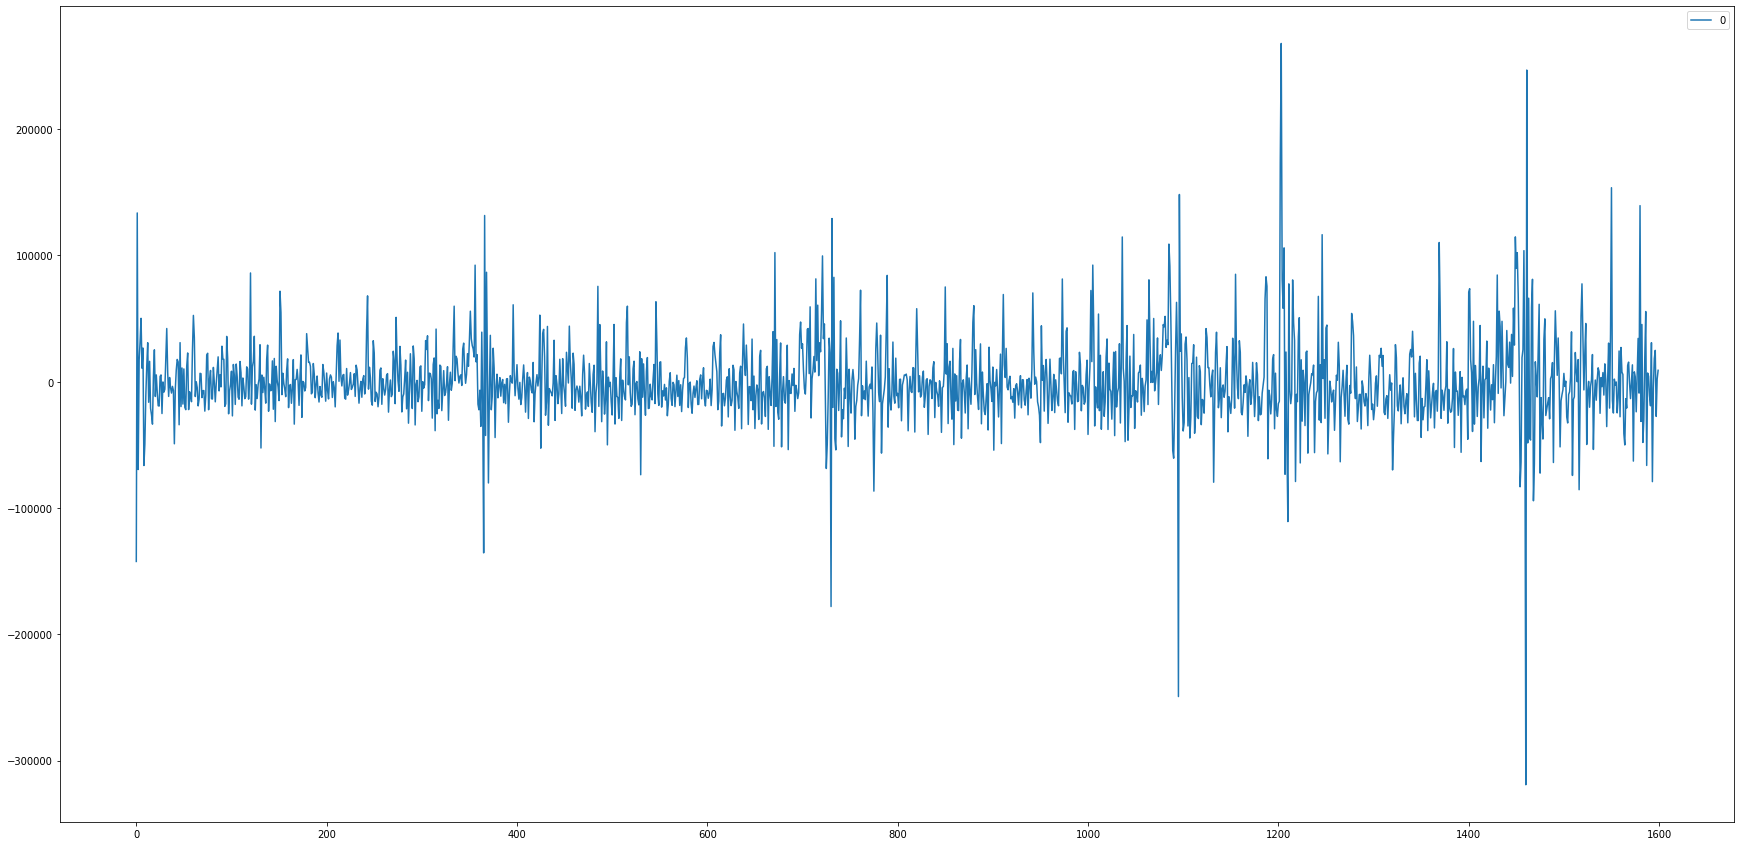

In [289]:
residuals = pd.DataFrame(arima_res.resid)
residuals.plot()


In [290]:
residuals.describe()

,0
count,1600.000000
mean,-0.321339
std,32805.690427
min,-319032.558455
25%,-15776.850083
50%,-2408.304253
75%,12981.301576
max,267857.087700


Se hace la predicción y se grafica el intervalo de confianza

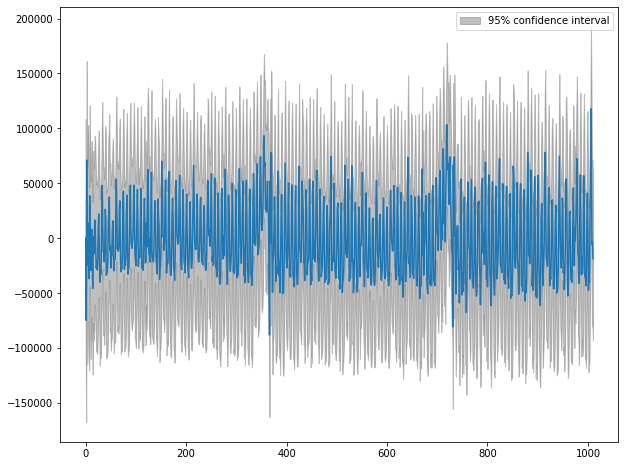

In [291]:
N = 1000
l = 10
fig, ax = plt.subplots(figsize=(10, 8))
plot_predict(arima_res, start=0, end=N + l, ax=ax)
plt.show()

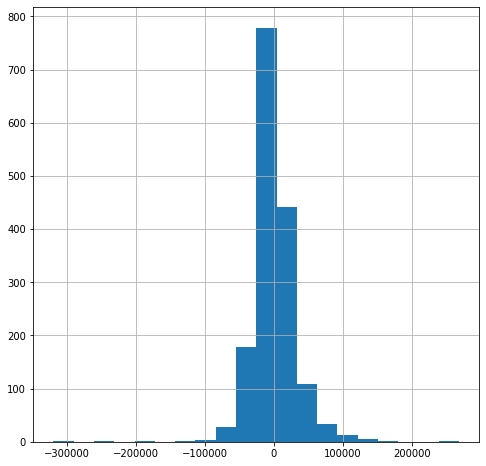

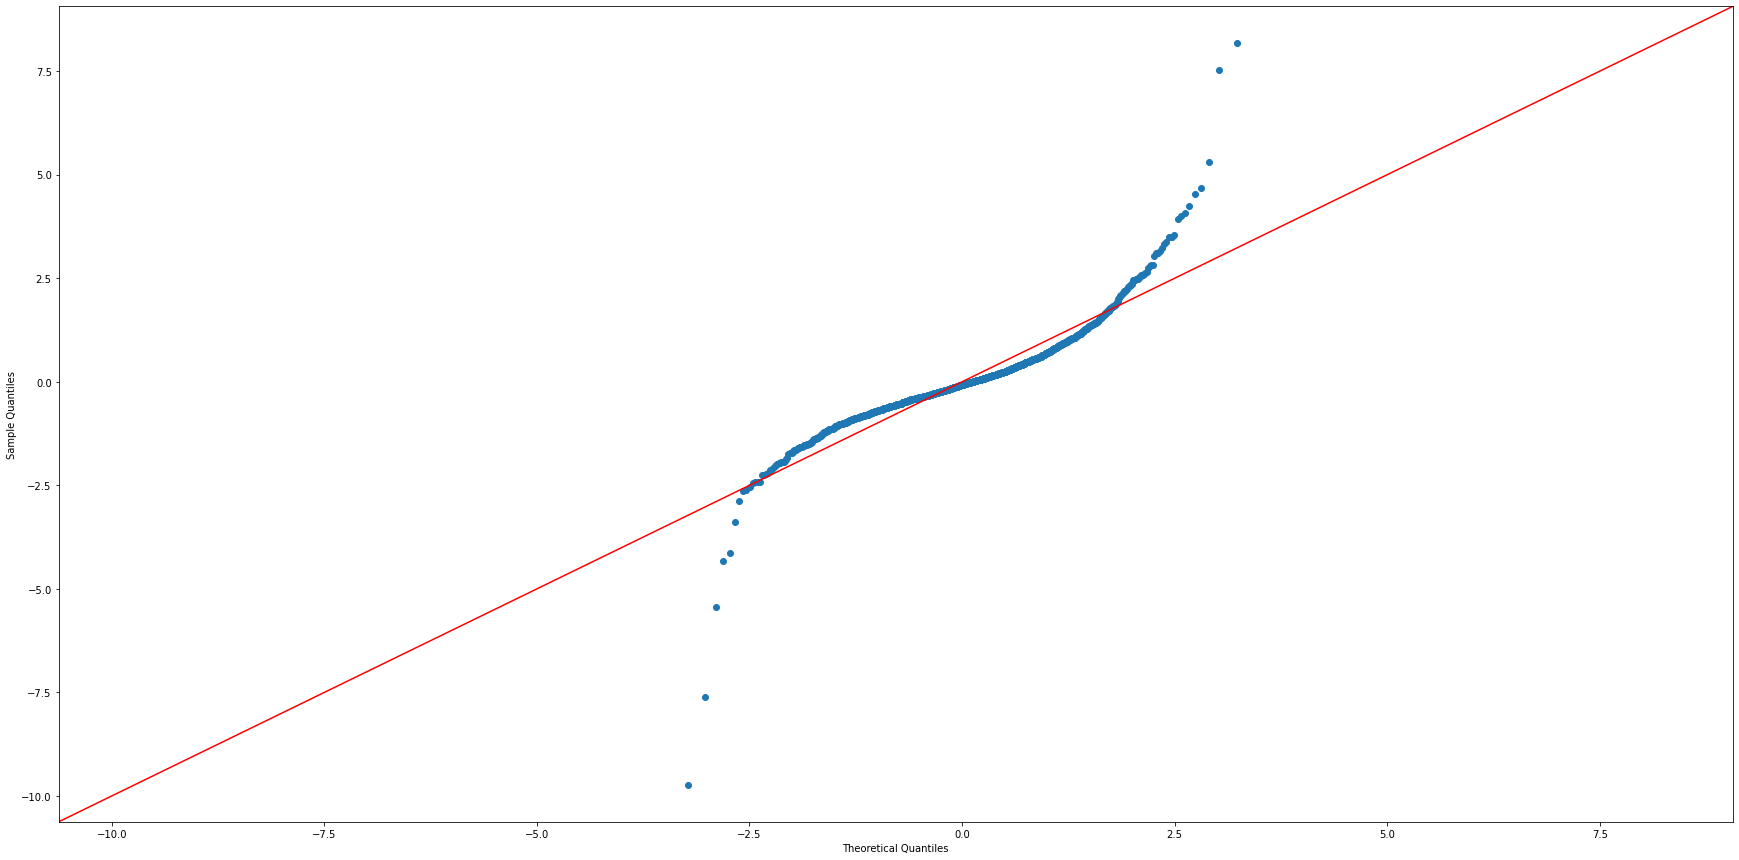

In [292]:

mean = np.mean(residuals.values.flatten())
std = np.std(residuals.values.flatten())

plt.show()
plt.figure(figsize=(8, 8))
plt.grid()
plt.hist(np.array(residuals.values.flatten()), bins=20)

fig = sm.qqplot((residuals.values.flatten() - mean) / std, line="45")


In [293]:
acorr_ljungbox(residuals, lags=[7], return_df=True)

,lb_stat,lb_pvalue
7,2.730764,0.908742


### Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x26c3f9966b0>,
 'caps': [<matplotlib.lines.Line2D at 0x26c3f9b9c30>,
 'boxes': [<matplotlib.lines.Line2D at 0x26c3f996c50>],
 'medians': [<matplotlib.lines.Line2D at 0x26c3f9ba470>],
 'fliers': [<matplotlib.lines.Line2D at 0x26c3f9b8100>],
 'means': []}

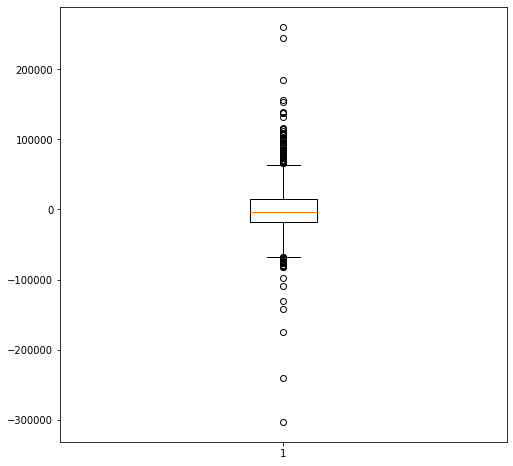

In [283]:
plt.figure(figsize=(8, 8))
plt.boxplot(residuals)

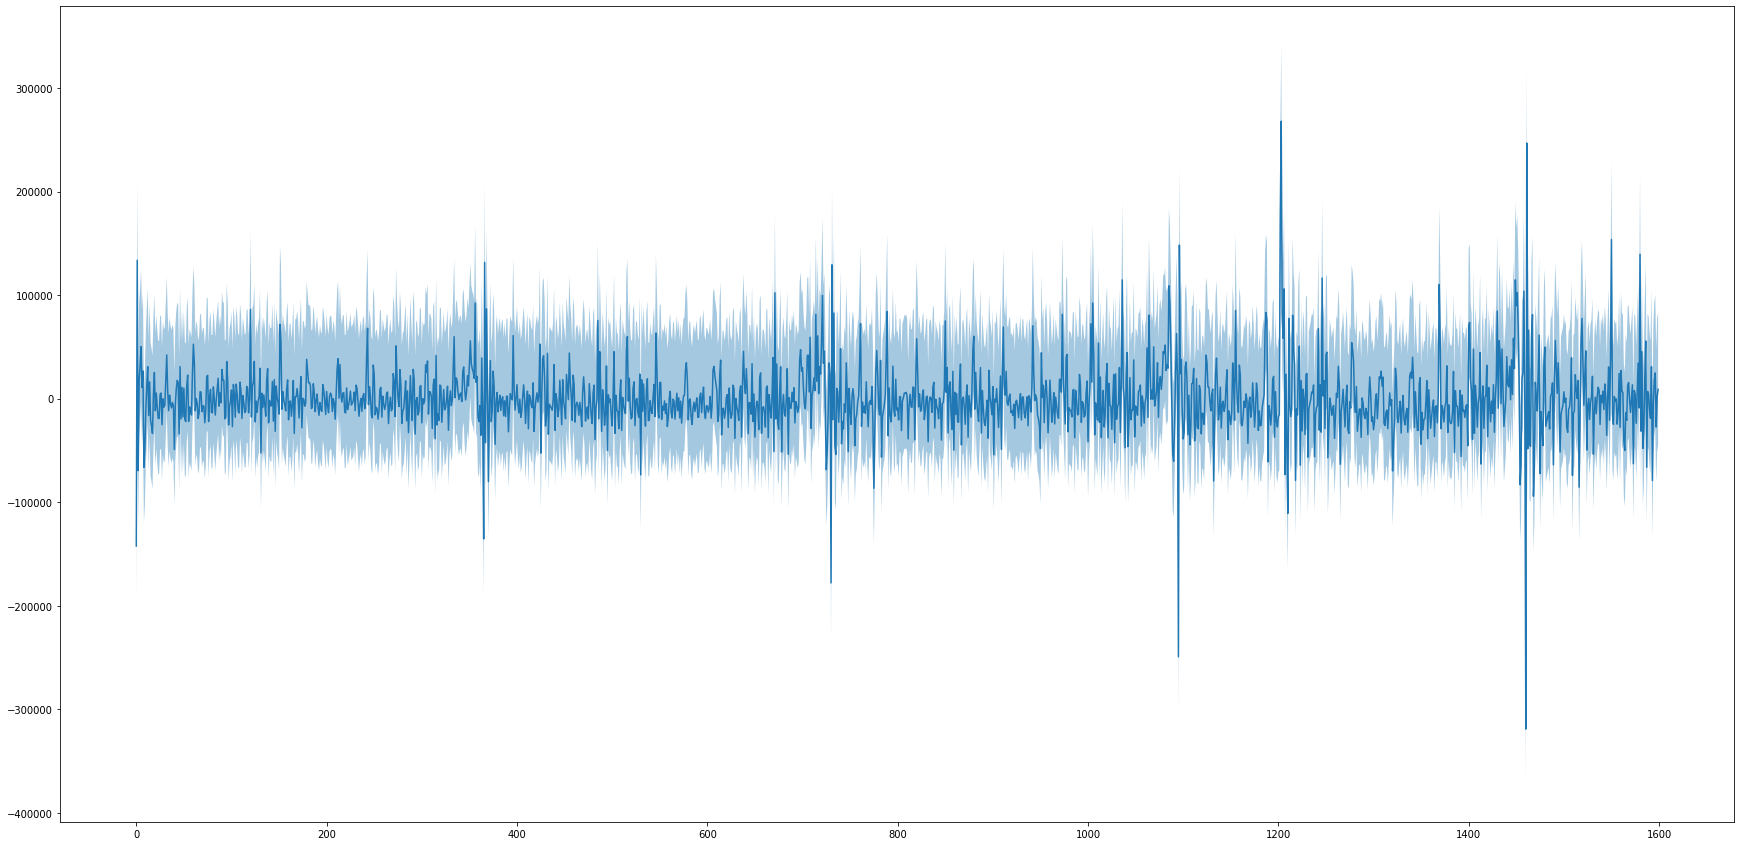

In [294]:
q975 = residuals.quantile(0.975)
q025 = residuals.quantile(0.025)
plt.plot(residuals)
plt.fill_between(
    x=residuals.index, 
    y1=(residuals + q025).values.flatten(),
    y2=(residuals + q975).values.flatten(),
    #y1=q025,
    #y2=q975,
    alpha=0.4
)

### Forcasting

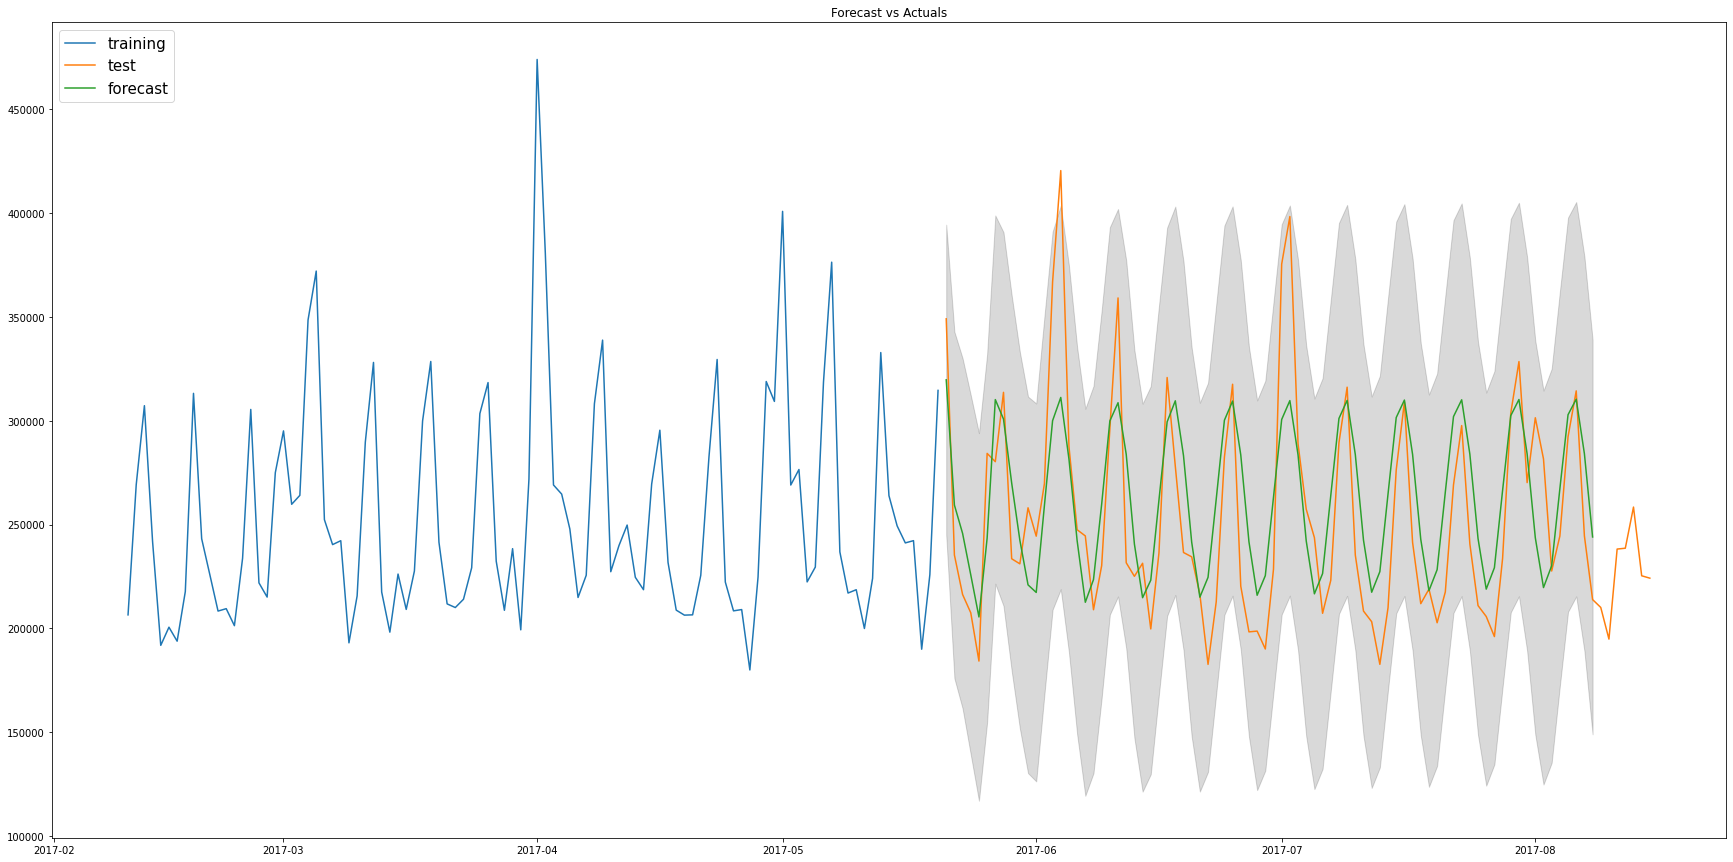

In [299]:
forecast = arima_res.get_forecast(80)
intervals = forecast.conf_int(alpha=0.05)


plt.plot((sales_per_day + tendency)[1500:], label='training')
plt.plot(sales_per_day_test, label='test')

fc_series = pd.Series(forecast.predicted_mean, index=sales_per_day_test.index[:len(forecast.predicted_mean)])
lower_series = pd.Series(intervals[:, 0], index=sales_per_day_test.index[:len(forecast.predicted_mean)])
upper_series = pd.Series(intervals[:, 1], index=sales_per_day_test.index[:len(forecast.predicted_mean)])

tendency_forecast_x = mdates.date2num(fc_series.index)
tendency_forecast_y = popt[0] * tendency_forecast_x + popt[1]

plt.plot(fc_series + tendency_forecast_y, label='forecast')
plt.fill_between(fc_series.index, lower_series + tendency_forecast_y, upper_series + tendency_forecast_y, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=15)
plt.show()


### SARIMA

In [313]:
model_sarima = sm.tsa.statespace.SARIMAX(sales_per_day.values, order=(4, 0, 4), seasonal_order=(4, 0, 4, 7), enforce_stationarity=False, enforce_invertibility=False)
sarima_res = model_sarima.fit()
print(sarima_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1600
Model:             SARIMAX(4, 0, 4)x(4, 0, 4, 7)   Log Likelihood              -18480.088
Date:                           Tue, 07 Jun 2022   AIC                          36994.176
Time:                                   22:51:45   BIC                          37085.244
Sample:                                        0   HQIC                         37028.028
                                          - 1600                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0063      0.297      3.389      0.001       0.424       1.588
ar.L2         -1.0222      0.254     -4.020

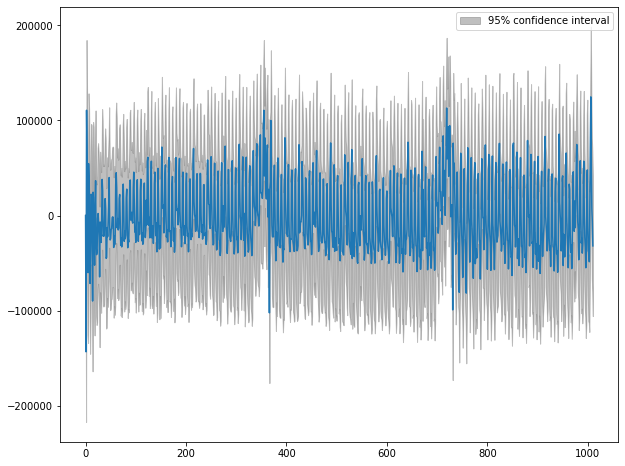

In [314]:
N = 1000
l = 10
fig, ax = plt.subplots(figsize=(10, 8))
plot_predict(sarima_res, start=0, end=N + l, ax=ax)
plt.show()

<AxesSubplot:>

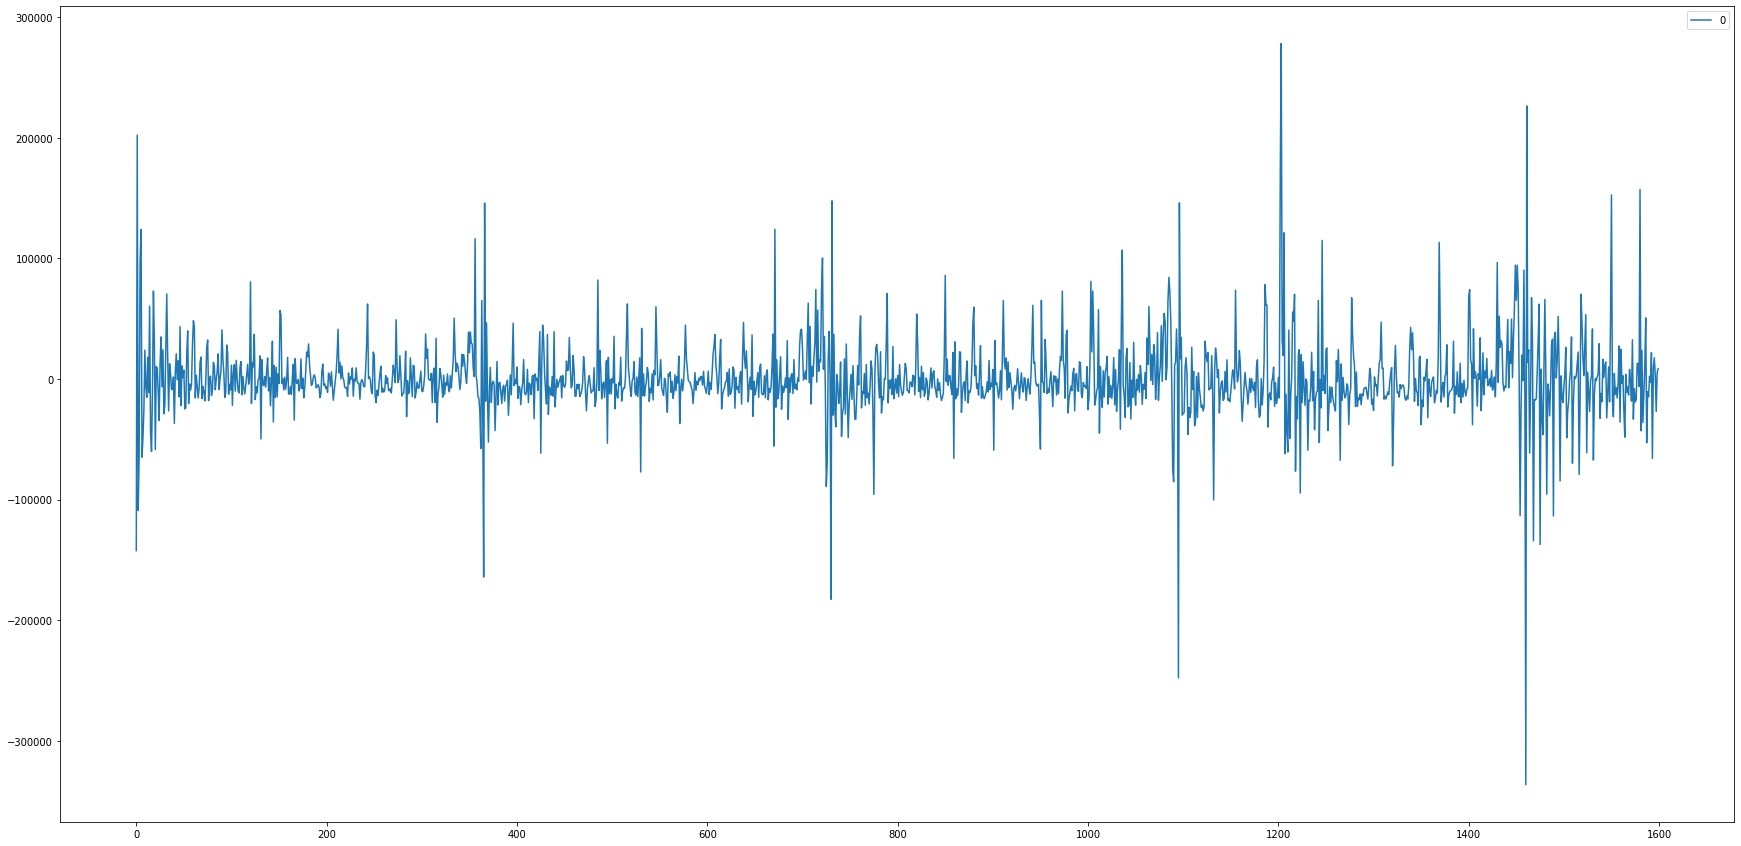

In [315]:
residuals = pd.DataFrame(sarima_res.resid)
residuals.plot()

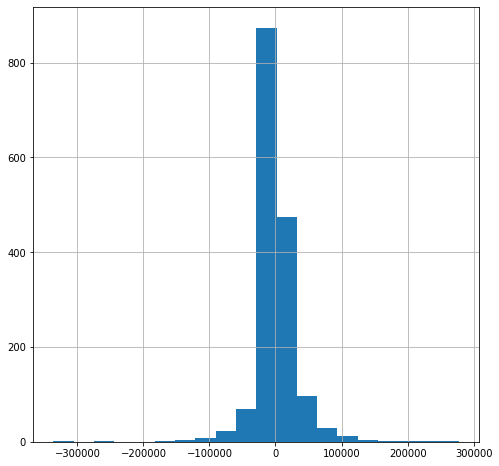

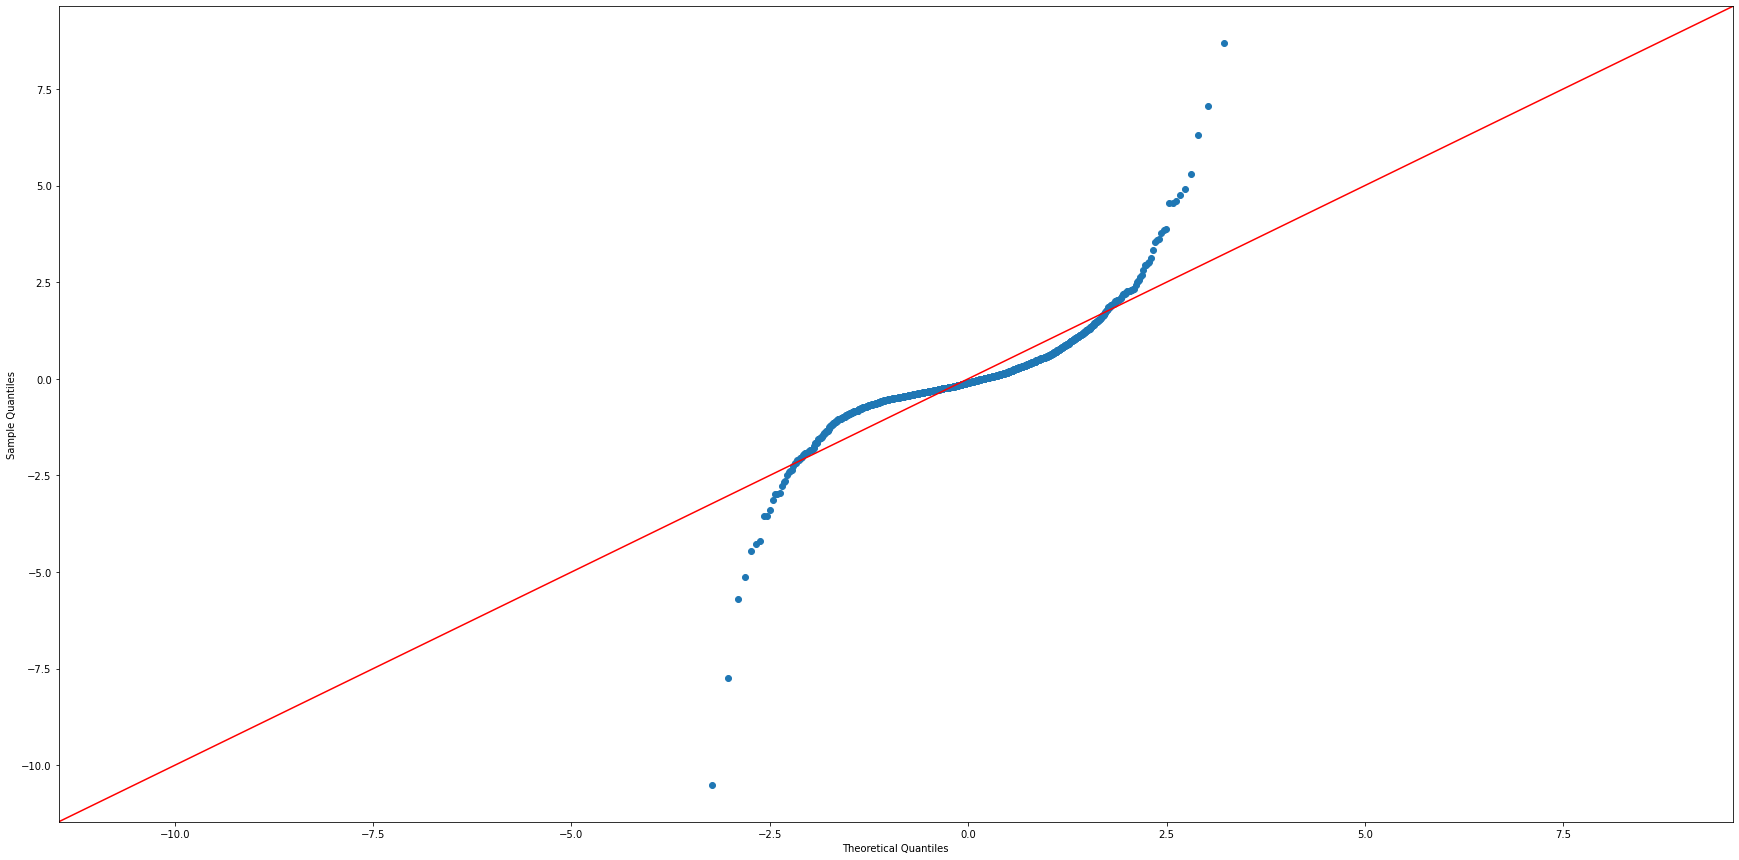

In [316]:

mean = np.mean(residuals.values.flatten())
std = np.std(residuals.values.flatten())

plt.show()
plt.figure(figsize=(8, 8))
plt.grid()
plt.hist(np.array(residuals.values.flatten()), bins=20)

fig = sm.qqplot((residuals.values.flatten() - mean) / std, line="45")

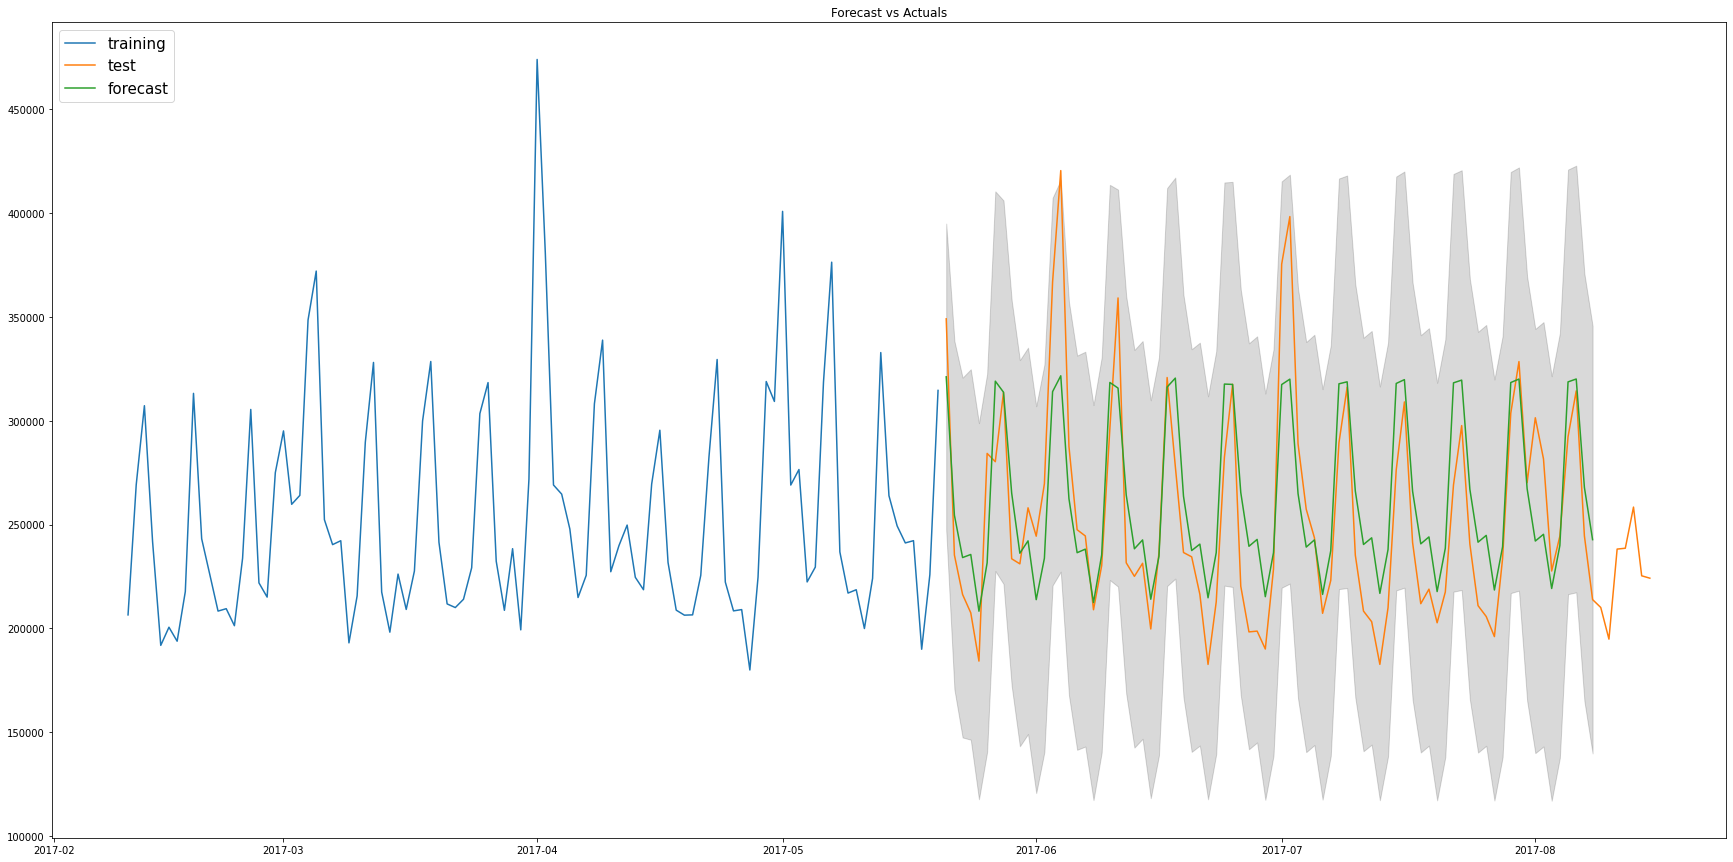

In [317]:
forecast = sarima_res.get_forecast(80)
intervals = forecast.conf_int(alpha=0.05)


plt.plot((sales_per_day + tendency)[1500:], label='training')
plt.plot(sales_per_day_test, label='test')

fc_series = pd.Series(forecast.predicted_mean, index=sales_per_day_test.index[:len(forecast.predicted_mean)])
lower_series = pd.Series(intervals[:, 0], index=sales_per_day_test.index[:len(forecast.predicted_mean)])
upper_series = pd.Series(intervals[:, 1], index=sales_per_day_test.index[:len(forecast.predicted_mean)])

tendency_forecast_x = mdates.date2num(fc_series.index)
tendency_forecast_y = popt[0] * tendency_forecast_x + popt[1]

plt.plot(fc_series + tendency_forecast_y, label='forecast')
plt.fill_between(fc_series.index, lower_series + tendency_forecast_y, upper_series + tendency_forecast_y, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=15)
plt.show()